# **Bank Customer Churn Prediction**

### **By Sivan Itzhaki**

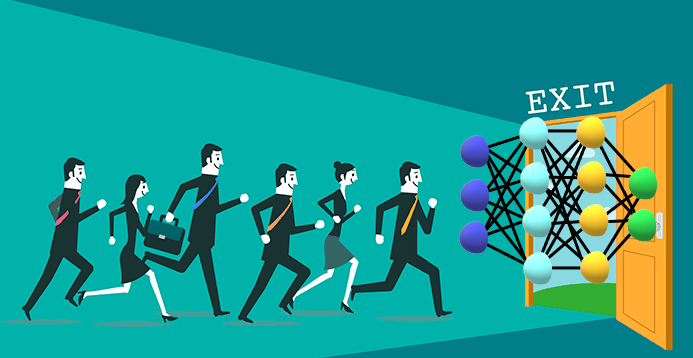

## **Customer Churn Prediction**  
The project focuses on **customer churn prediction** using **AutoML with H2O** to identify high-risk customers and enable proactive retention strategies.  
All models and their performance metrics were tracked using **MLflow** for reproducibility, monitoring, and comparison.  

---

### **Challenge**  
Customer churn is a critical issue for businesses, impacting revenue and long-term growth. Identifying customers at risk of leaving is challenging due to:  
- **Complex behavioral patterns** affecting churn decisions.  
- **Imbalanced data**, where churners are a minority.  

---

### **Solution: Machine Learning-Based Churn Prediction**  
Customer churn was predicted using a **Gradient Boosting Classifier (GBC) with AutoML**.  

---

## **Methodology**

## **Data Acquisition**  
The dataset was sourced from **Kaggle**, which provides real-world customer churn data, commonly used for predictive modeling in the banking sector.  


### **Data Cleaning & Feature Engineering**  
- **Column Removal & Creation**: Removed irrelevant columns and created new features to enhance model performance.  
- **Feature Transformation**: Applied **log transformation** and categorized numerical features for better interpretability.  
- **Encoding**: Performed **One-Hot Encoding** on categorical variables.  

---

### **Model Selection & Optimization**  
- **AutoML with H2O**: Evaluated two models – **Gradient Boosting Classifier (GBC)** and **Stacked Ensemble**.  
- **Performance Metric**: Optimized for **F1-score**, balancing precision and recall.  
- **Hyperparameter Tuning**: Fine-tuned using **Grid Search** to improve model performance.  
- **MLflow Tracking**: Logged model performance, parameters, and artifacts for experiment comparison and reproducibility.  

---

### **Evaluation & Interpretation**  
- **Feature Importance**: Identified **key churn predictors** (e.g., Age, Number of Products).  
- **SHAP Analysis**: Explained **how each feature impacts predictions**.  
- **Precision-Recall Curves**: Assessed model trade-offs.  

---

## **Outcome**  
A **churn prediction model**, supporting **data-driven retention strategies** by identifying at-risk customers and providing insights for proactive intervention.  

---

## **Future Improvements**  
- **Enhance feature engineering** (e.g., refine tenure representation, segment customers based on behavioral patterns).  
- **Explore alternative models** (e.g., SVM, KNN) for comparative performance evaluation.  
- **Align model objectives with business goals** (e.g., prioritize recall for maximum churn detection or precision to minimize unnecessary interventions).  
- **Segment-Based** Churn Prediction

### Now, let's dive into the details:


### Installs

In [ ]:
!pip install pyngrok
!pip install -U h2o
!pip install mlflow==2.19.0

## Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (accuracy_score, f1_score, recall_score, precision_score,
                             roc_auc_score, confusion_matrix, classification_report, roc_curve)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
import mlflow
import mlflow.sklearn
import joblib
import shap
import os
import warnings
import h2o
from h2o.automl import H2OAutoML
from h2o.frame import H2OFrame

import mlflow.h2o
from pyngrok import ngrok
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch
import subprocess
from pyngrok import ngrok, conf
import getpass
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, roc_auc_score, auc


warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

%config InlineBackend.figure_format = 'retina'

# to display all columns and rows:
#pd.set_option('display.max_columns', None); pd.set_option('display.max_rows', None);

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Data Loading and Initial Exploration

In [ ]:
drive_base_path = "churn_prediction"
df_path = os.path.join(drive_base_path, "churn.csv")
models_path = os.path.join(drive_base_path, "H2O_Models")
df = pd.read_csv(df_path)
df_original = df.copy()

In [ ]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
df.shape

(10000, 14)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


None of the columns is having missing values.
So we don't have to perform Data Imputation.

In [ ]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [ ]:
df.nunique()

,0
RowNumber,10000
CustomerId,10000
Surname,2932
CreditScore,460
Geography,3
Gender,2
Age,70
Tenure,11
Balance,6382
NumOfProducts,4


## Data Cleaning and Preprocessing

From the above, I will not require the first 2 attributes as they are specific to a customer. It is borderline with the surname as this would result to profiling so I exclude this as well.


In [ ]:
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis=1)

I am identifying numerical and categorical columns to better understand the dataset structure. This distinction will help in preprocessing steps such as scaling numerical features and encoding categorical variables.

In [ ]:
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

In [ ]:
print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
Categorical Columns: ['Geography', 'Gender']


## Exploratory Data Analysis (EDA)

### Histogram of Numerical Features by Churn


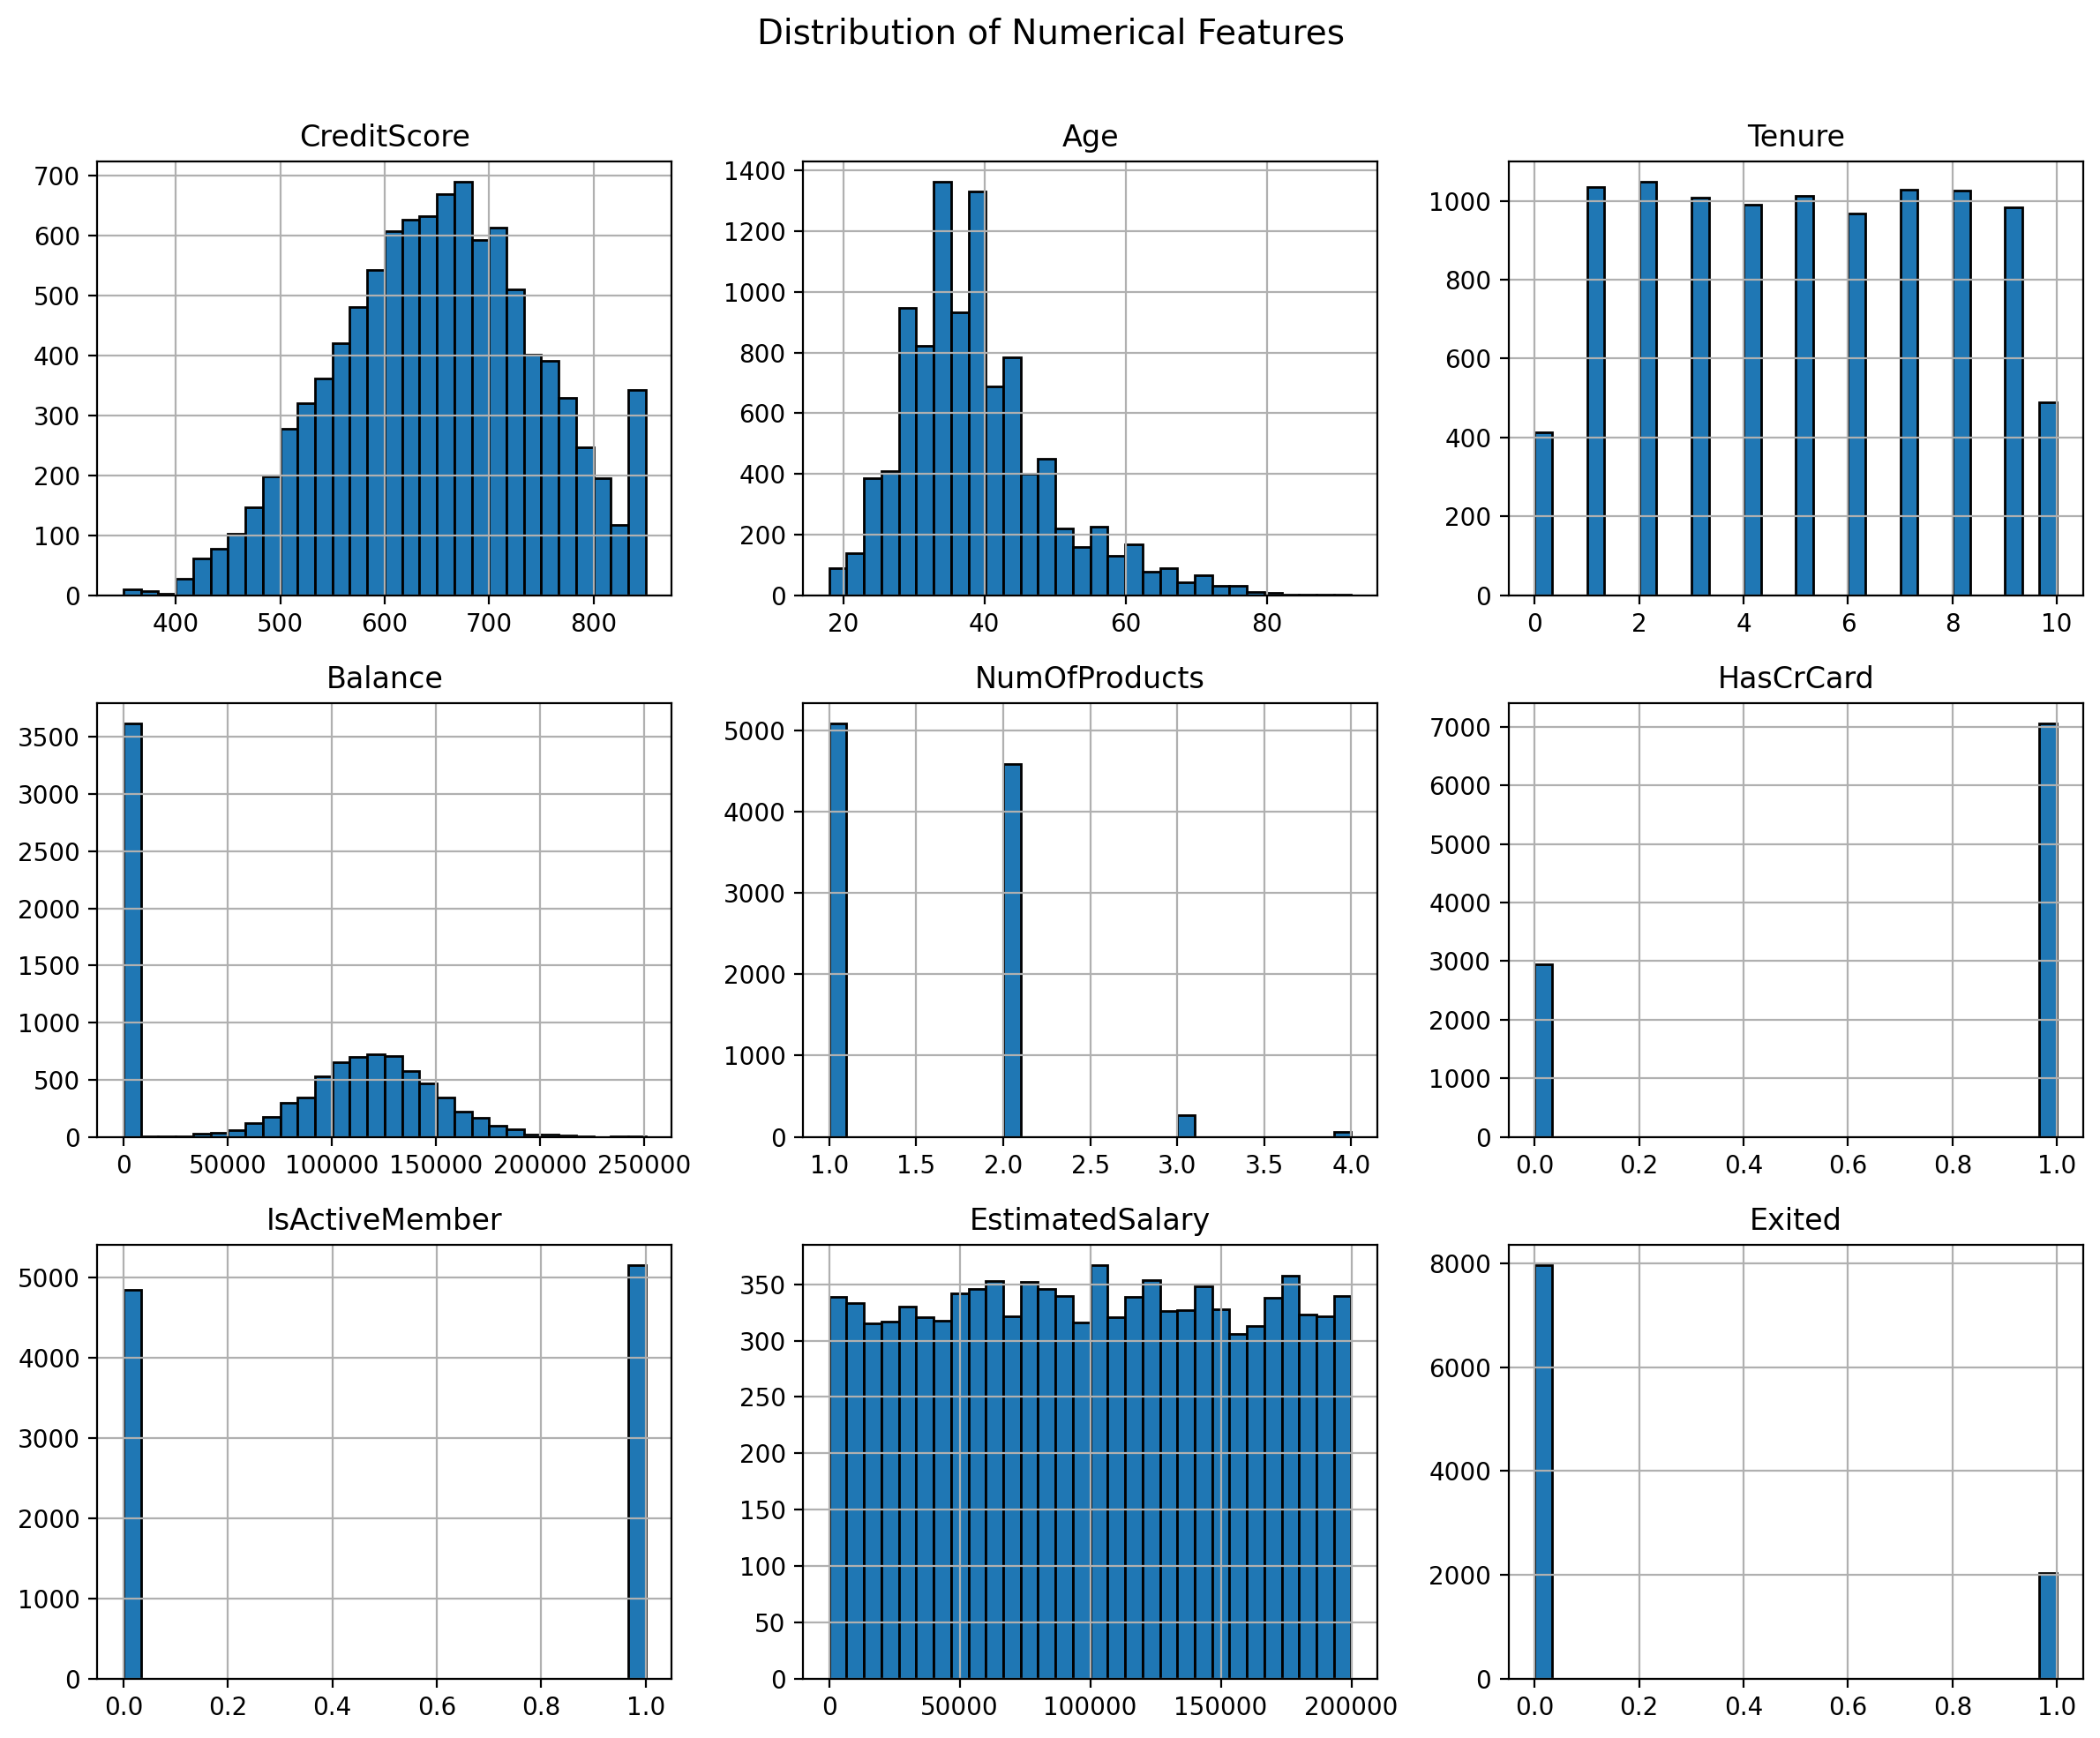

In [ ]:
df[numerical_cols].hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.suptitle("Distribution of Numerical Features", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### Distribution Analysis of Key Features

- **Age**: The distribution is right-skewed, with most customers in their 30s and 40s. There are fewer younger and older customers.
- **Balance**: A large portion of customers have a zero balance, while the rest follow a roughly normal distribution.
- **Number of Products**: Most customers have either one or two products, with very few having three or more.
- **Credit Score**: The distribution is approximately normal but slightly skewed, with most values concentrated between 600 and 750.

### The Distribution of Churned Customers


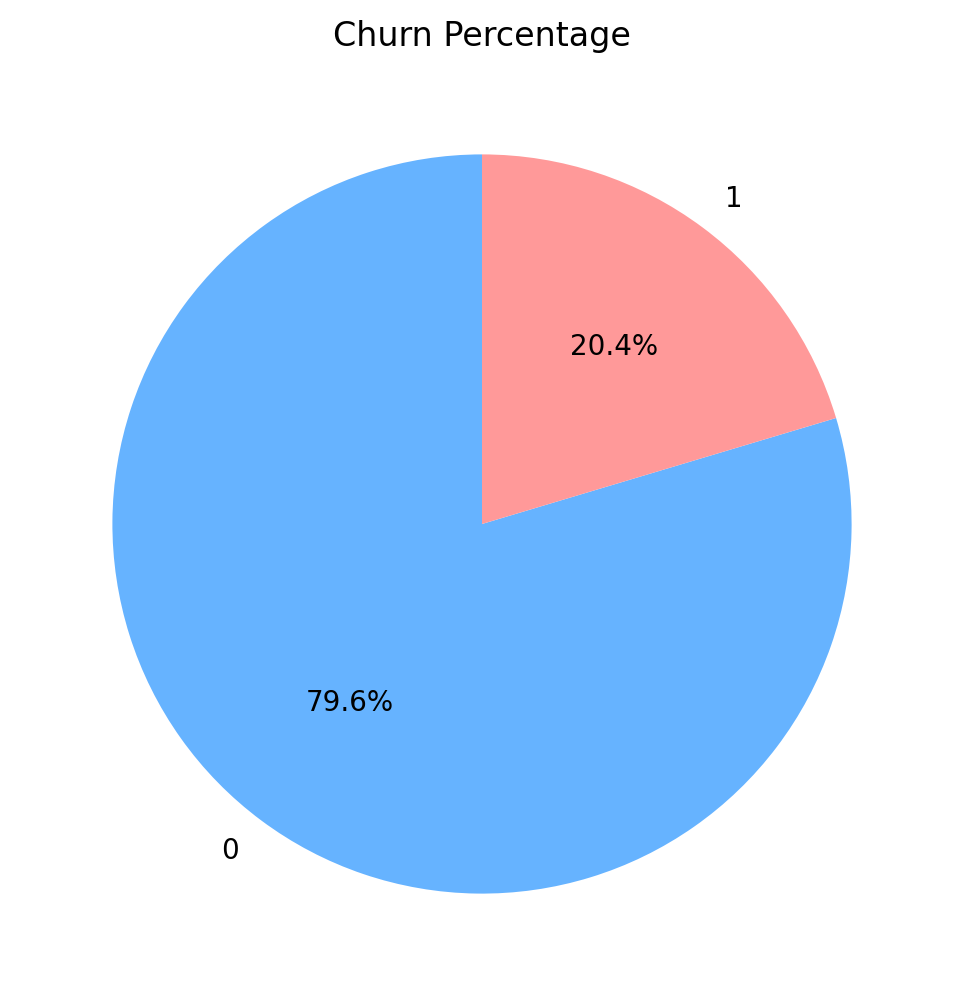

In [ ]:
plt.figure(figsize=(8, 6))
df["Exited"].value_counts().plot(kind="pie", autopct="%1.1f%%",
                                 colors=['#66b3ff', '#ff9999'], startangle=90)
plt.title("Churn Percentage")
plt.ylabel("")
plt.show()

### Churn Rate Analysis

From the pie chart, I can see that **20.4%** of customers have churned (Exited = 1), while **79.6%** have remained (Exited = 0).
This means that my dataset is **imbalanced**, which could affect model performance. Before building a predictive model, I need to handle this imbalance using SMOTE.

Next, I'll explore how churn is distributed across different features to identify key patterns and insights.


## Relationship Between 'Exited' and Categorical Features

<Axes: xlabel='Tenure', ylabel='count'>

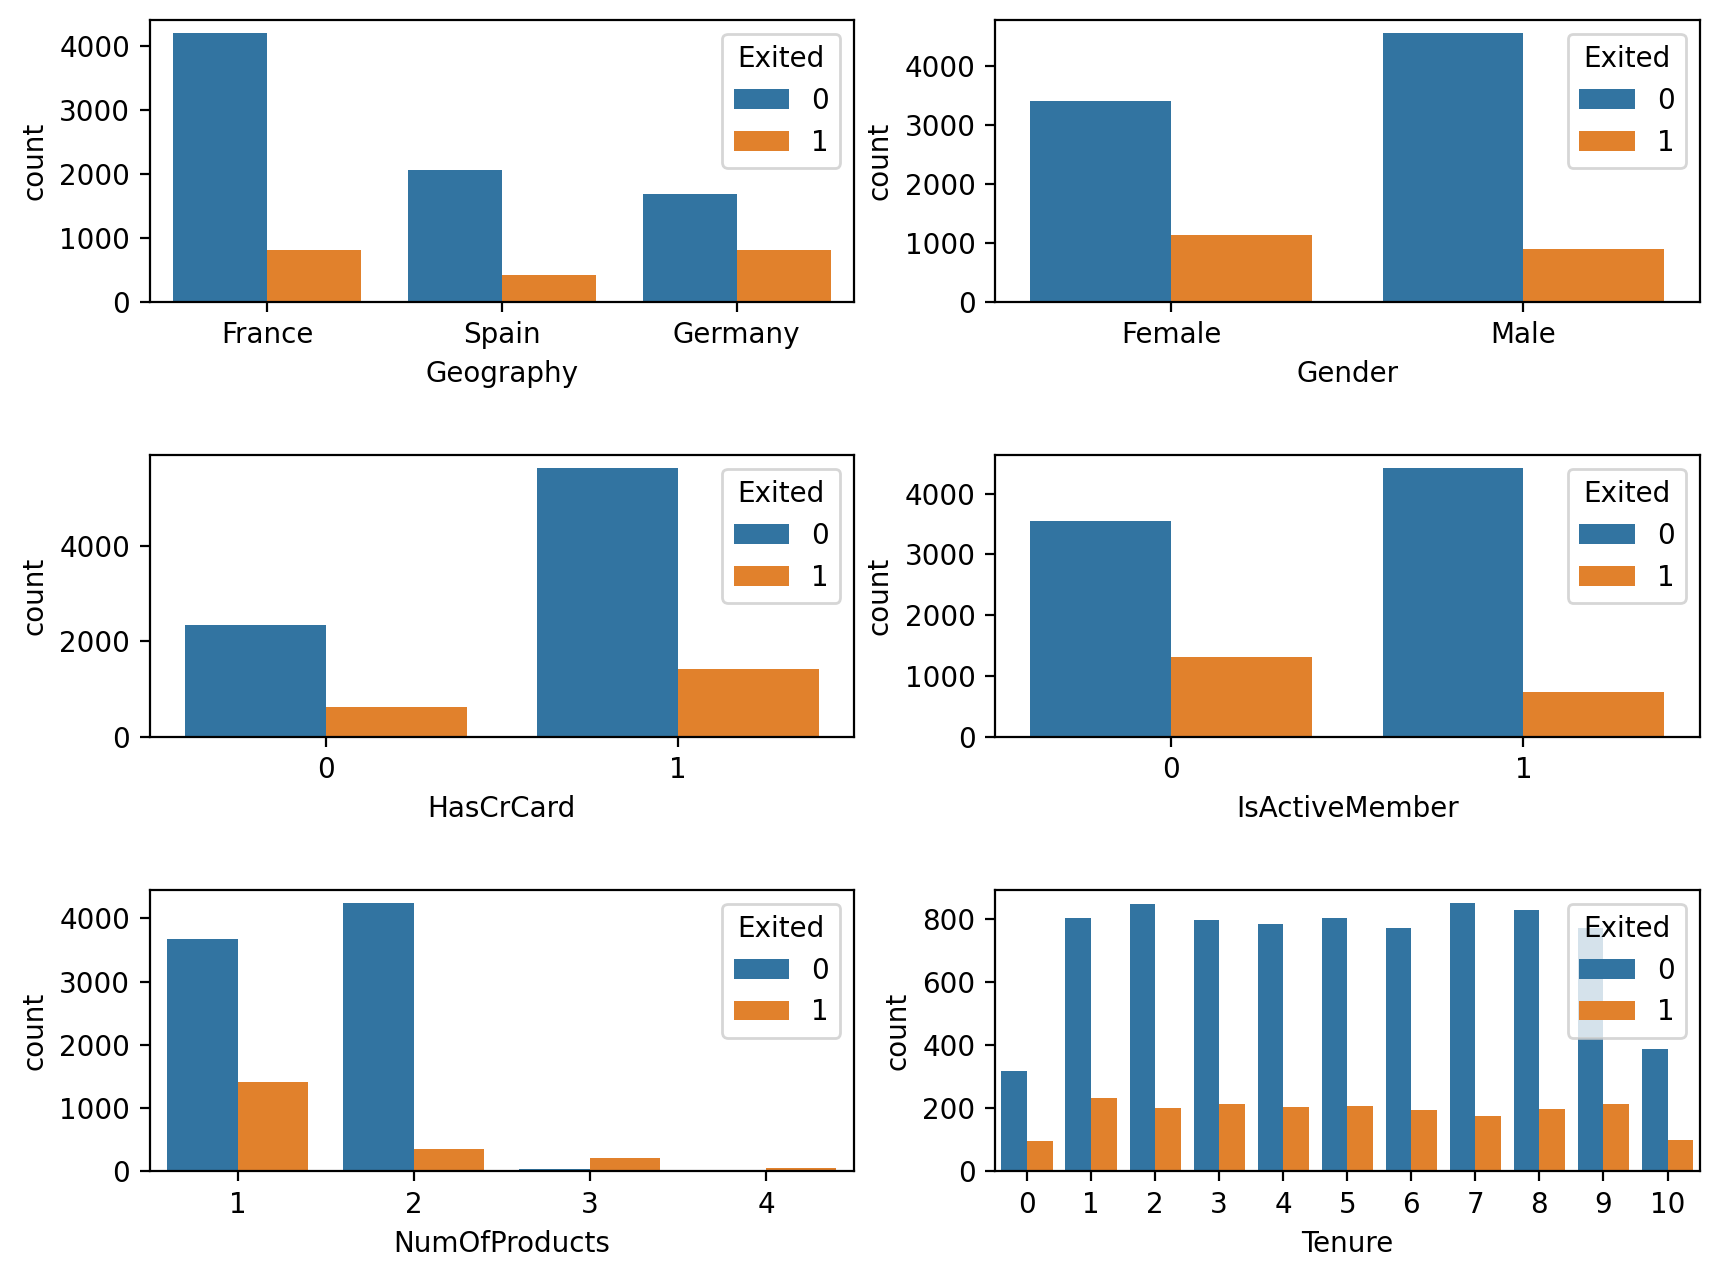

In [ ]:
fig, axarr = plt.subplots(3, 2, figsize=(10, 8))
for ax in axarr.flat:
    ax.set_box_aspect(0.4)
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])
sns.countplot(x='NumOfProducts', hue = 'Exited',data = df, ax=axarr[2][0])
sns.countplot(x='Tenure', hue = 'Exited',data = df, ax=axarr[2][1])

### Key Insights

- **Geography**: Most customers are from France, but churn is higher in countries with fewer clients, possibly due to limited customer service.
- **Gender**: Female customers tend to churn more than males.
- **Is Active Member**: Inactive members have a higher churn rate; the bank could benefit from engagement programs.
- **Has Credit Card**: Most customers have one, but it has little impact on churn (ratio ~1:4).
- **Num of Products**: Customers with **exactly 2 products** have the lowest churn, while those with **1 or more than 2** churn more.
  - **Feature Engineering**: Grouping customers with **more than 2 products** can help balance the classes.
  - **Recommendation**: The bank should encourage **at least 2 products** via rewards/incentives.
- **Tenure**: No clear impact on churn as distributions are similar.

### Feature Correlation Heatmap


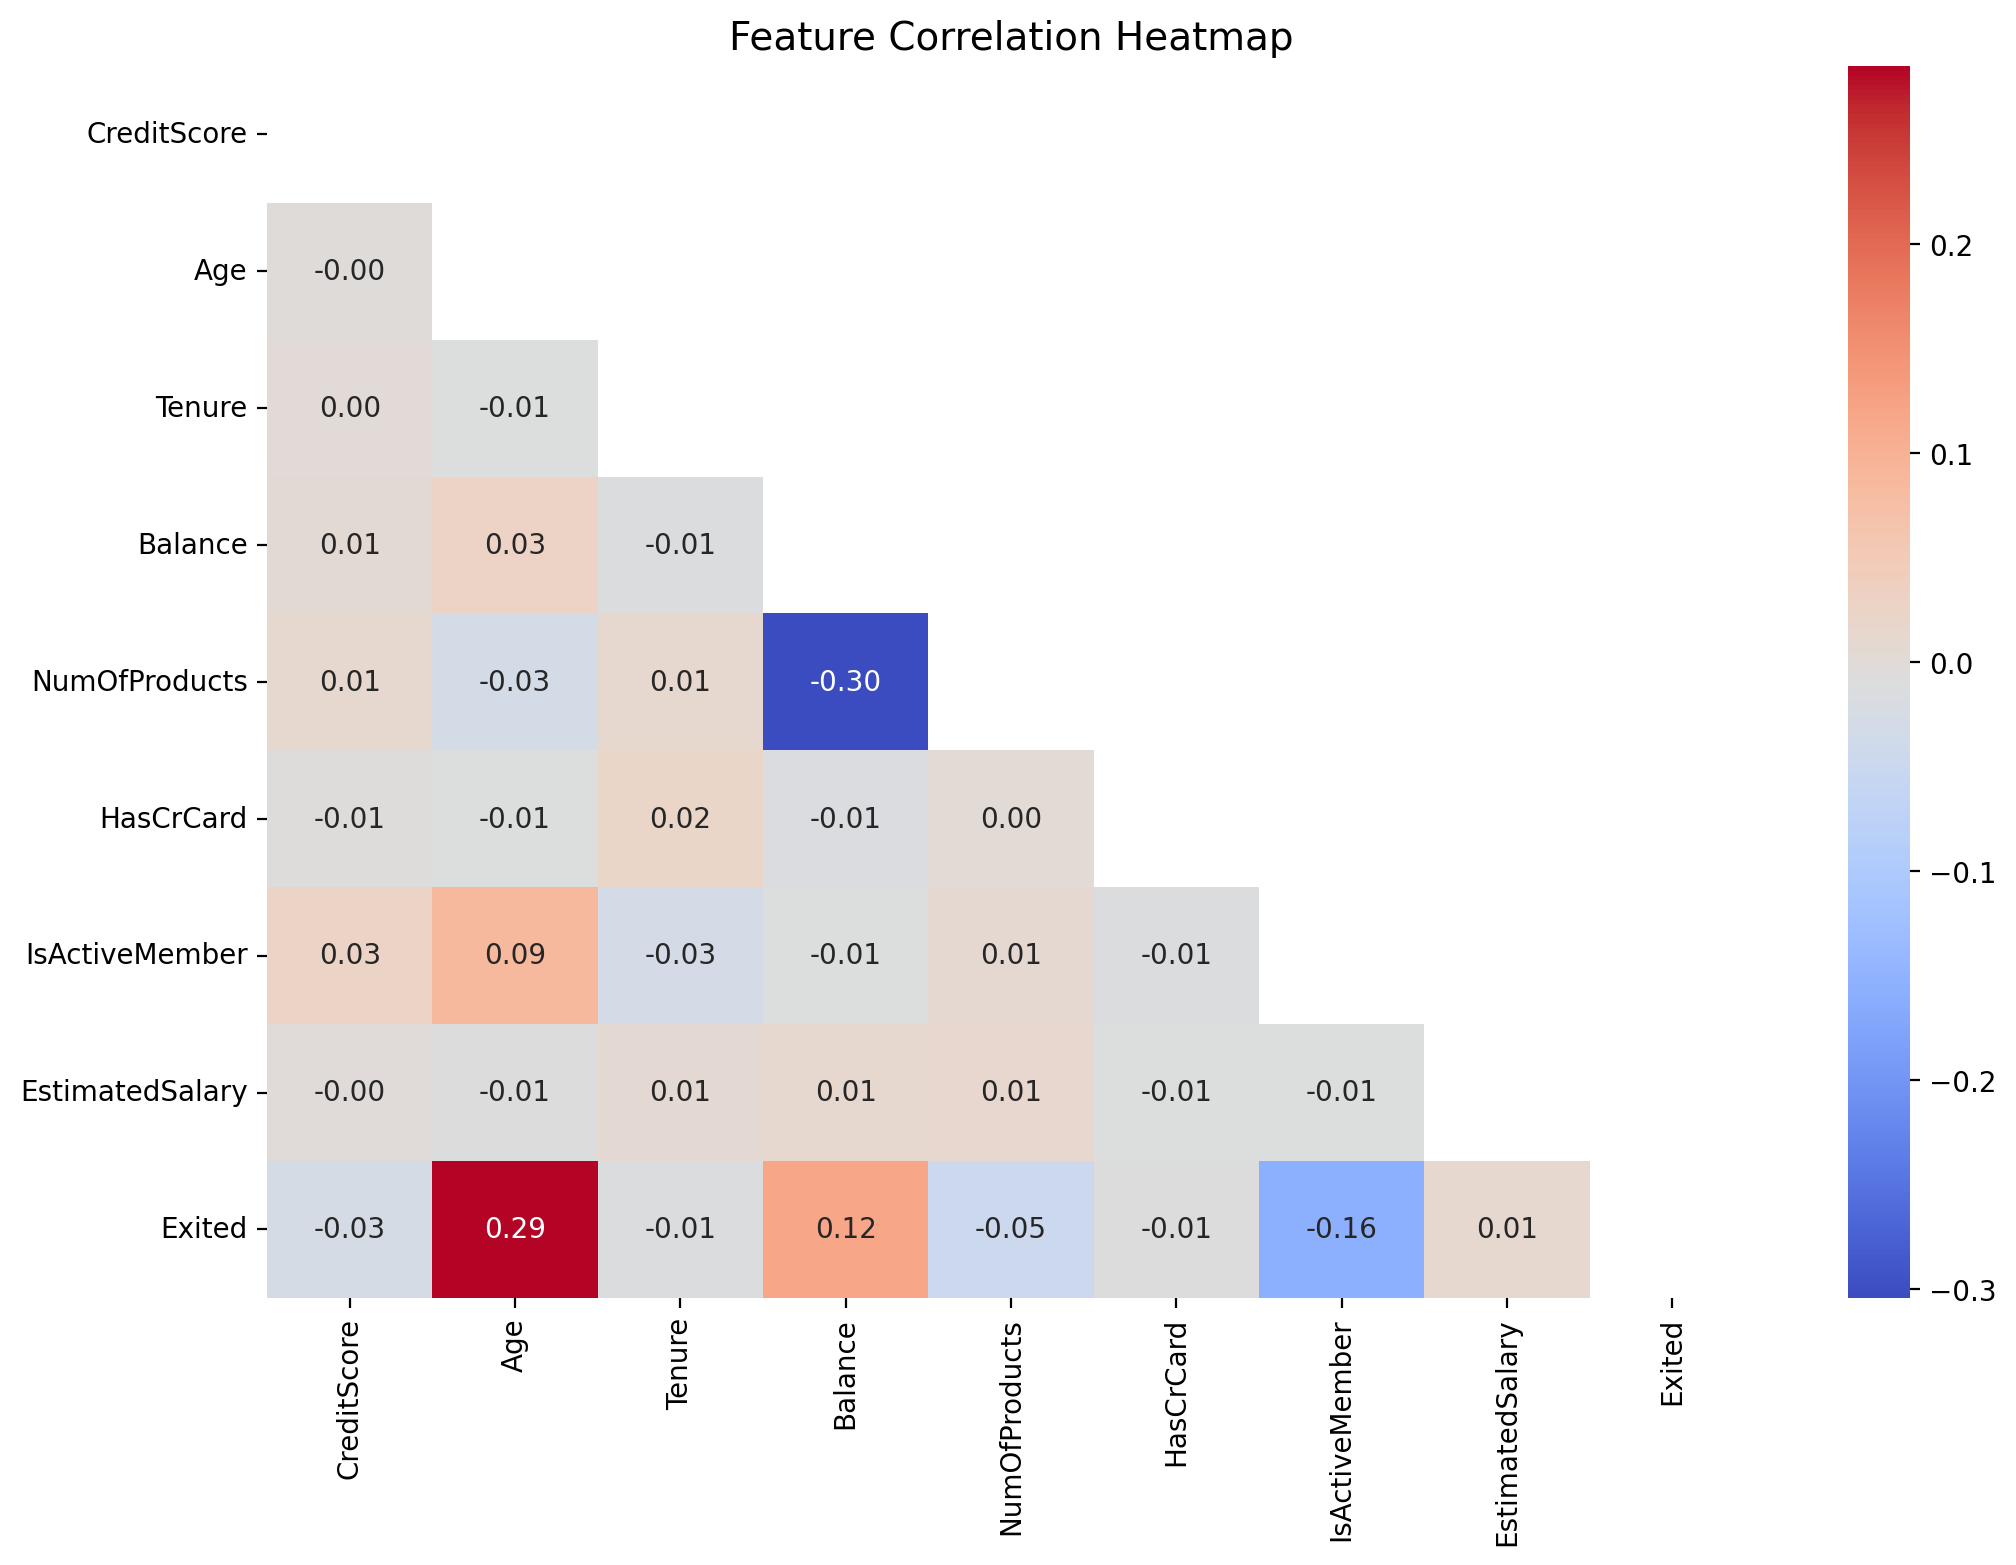

In [ ]:
plt.figure(figsize=(12, 8))
numerical_df = df.select_dtypes(include=['number'])
correlation = numerical_df.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f", mask=mask)
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()

### Investigating Highly Correlated Features

From the correlation heatmap, I identified several features that show a moderate correlation with churn (`Exited`). To gain deeper insights, I will further analyze these variables:

- **Age (0.29 correlation with Exited)** – Older customers appear to churn more frequently.
- **Balance (0.12 correlation with Exited)** – Customers with higher balances show slightly higher churn.
- **IsActiveMember (-0.16 correlation with Exited)** – Inactive members are more likely to churn.
- **NumOfProducts (-0.30 correlation with Exited)** – Customers with fewer products are more likely to churn.

To explore these relationships, I will use histograms and boxplots to visualize their distributions across churned and non-churned customers.


In [ ]:
def plot_feature_distribution(feature):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df, x=feature, hue="Exited", kde=True, bins=30, palette=["#66b3ff", "#ff9999"])
    plt.title(f"Distribution of {feature} by Churn Status")
    plt.xlabel(feature)
    plt.ylabel("Count")

    plt.subplot(1, 2, 2)
    sns.boxplot(x="Exited", y=feature, data=df, palette=["#66b3ff", "#ff9999"])
    plt.title(f"{feature} by Churn Status")
    plt.xlabel("Churned")
    plt.ylabel(feature)
    plt.xticks([0, 1], ["No", "Yes"])

    plt.tight_layout()
    plt.show()

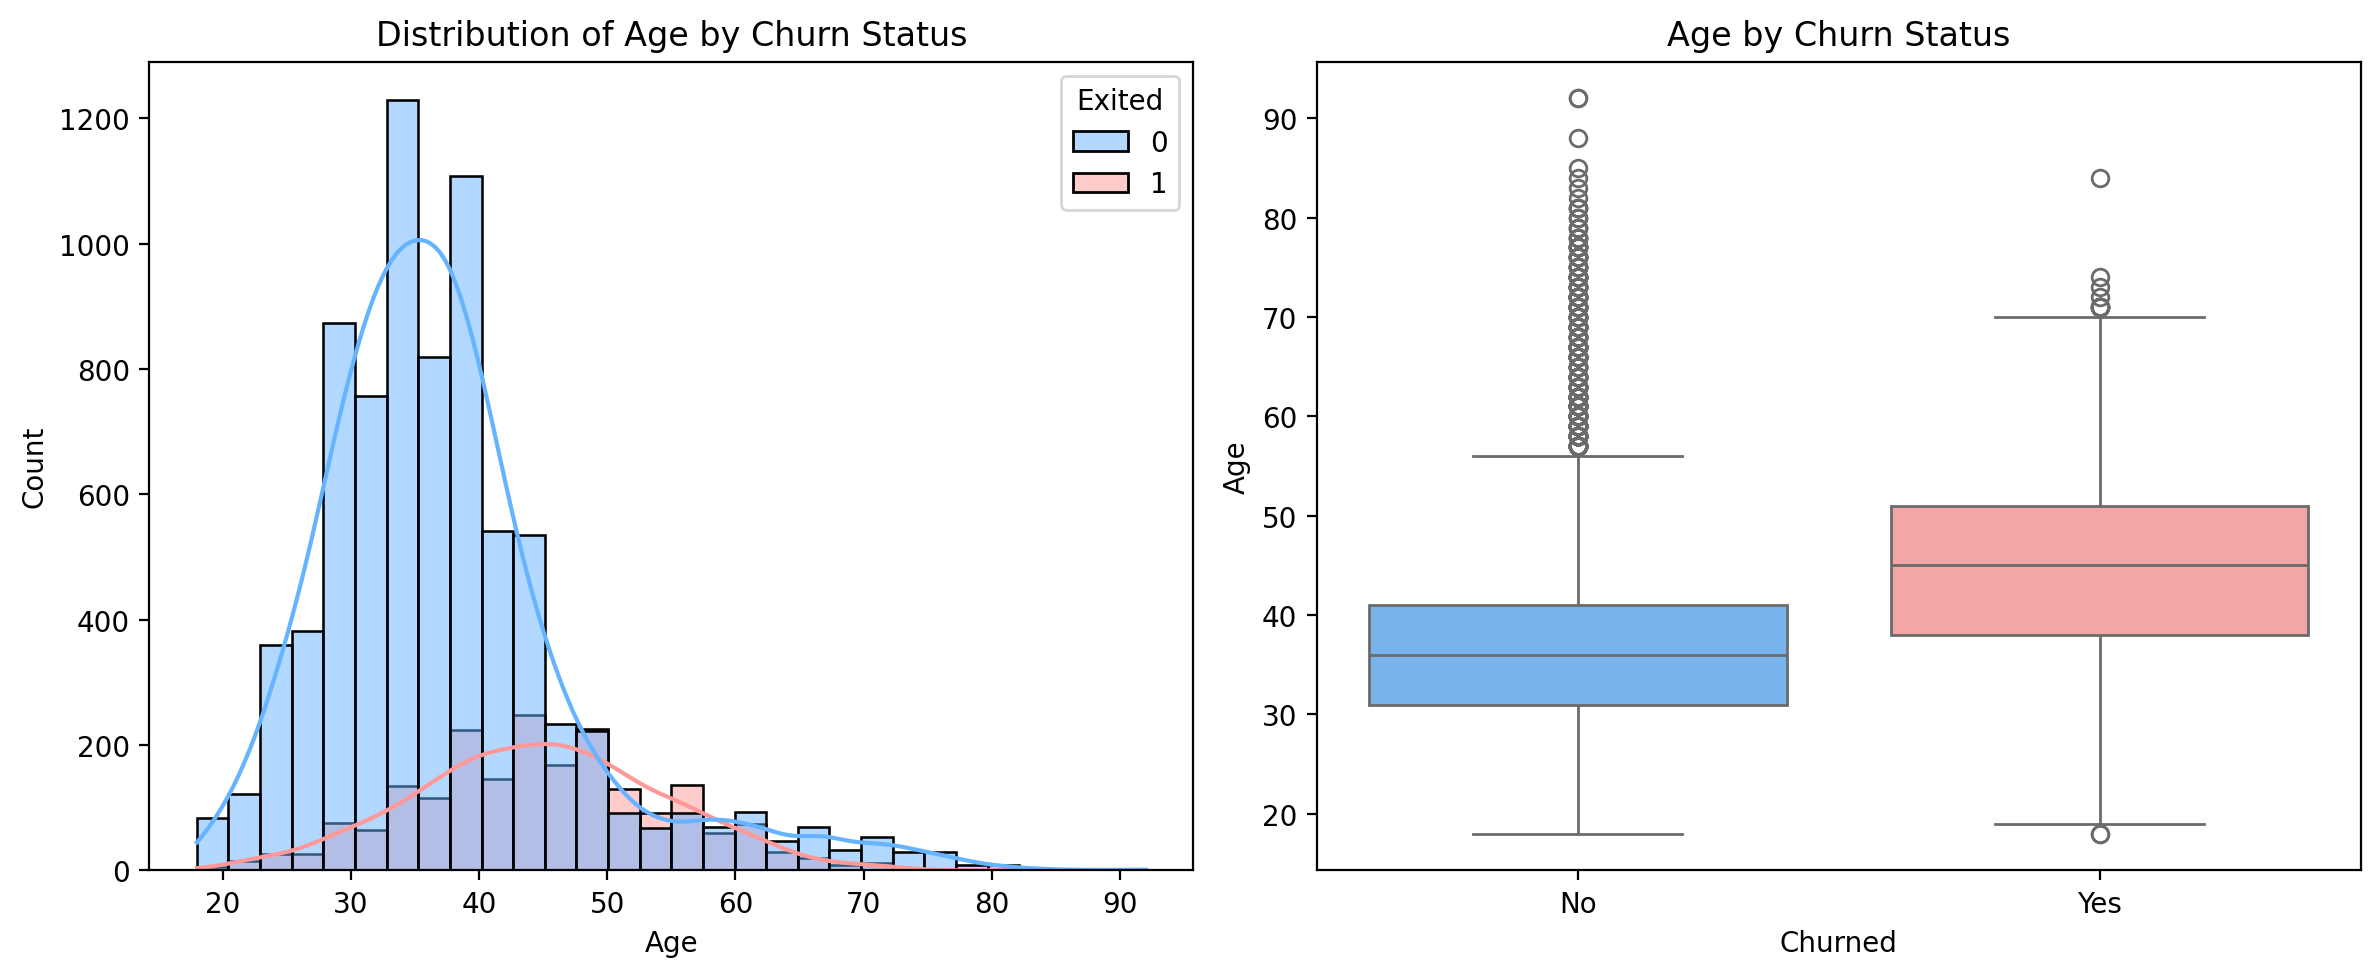

In [ ]:
plot_feature_distribution("Age")

The distribution is right skewed because of presence of outliers which can lead to overfitting in model.
To overcome this right-skewed distribution I can use log normal transformation technique to bring a normal distribution.


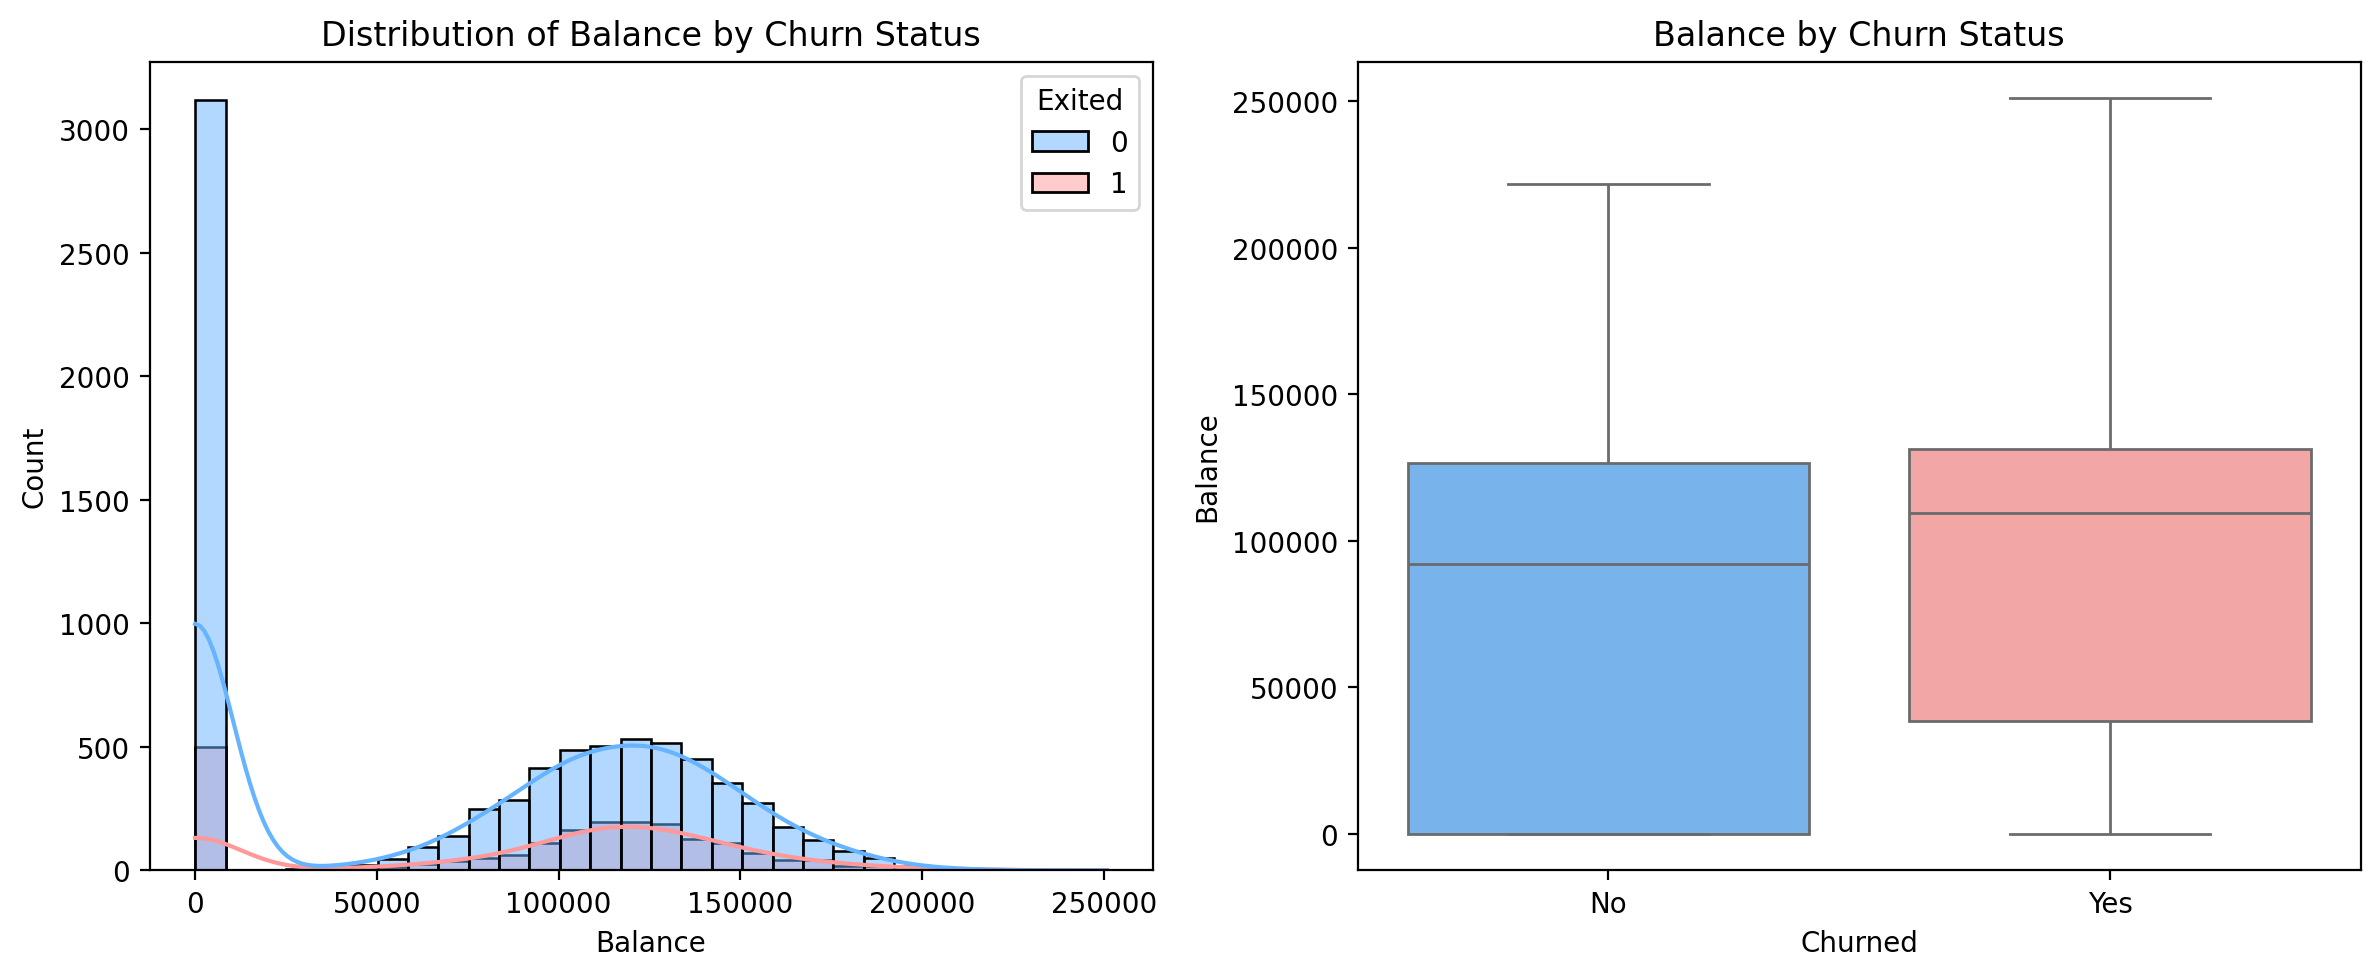

In [ ]:
plot_feature_distribution("Balance")

More than 3000 customers are having their account balance equal to zero.
Excluding the zero value I can observe a normal distribution. So don't have to use any other techniques.

I will do Feature Engineering by grouping the customers with account balance equal to 0 and balance more than 0 separately.



# **Preprocessing**

## Feature Engineering

1. Creating New Feature From "NumOfProducts" Feature.


In [ ]:
conditions = [
    (df["NumOfProducts"] == 1),
    (df["NumOfProducts"] == 2),
    (df["NumOfProducts"] > 2)
]
values = ["One_product", "Two_Products", "More_Than_2_Products"]

df["Total_Products"] = np.select(conditions, values, default="Unknown")
df.drop(columns="NumOfProducts", inplace=True)


 Log Transformation on Age Column
 -This will help model to find more relevant patterns and build a more accurate model.

In [ ]:
df["Log_Age"] = np.log(df["Age"])
df.drop(columns="Age", inplace=True)

Creating New Feature From "Balance" Feature

In [ ]:
conditions = [(df["Balance"] == 0), (df["Balance"] > 0)]
values = ["Zero_Balance", "More_Than_Zero_Balance"]
df["Account_Balance"] = np.select(conditions, values, default="Unknown")

df.drop(columns="Balance", inplace=True)

Performing One Hot Encoding on Categorical Features.

In [ ]:
cat_cols = ["Geography", "Gender", "Total_Products", "Account_Balance"]
df = pd.get_dummies(data=df, columns=cat_cols, prefix="", prefix_sep="")

In [ ]:
bool_cols = df.select_dtypes(include=["bool"]).columns
if not bool_cols.empty:
    df = df.astype({col: int for col in bool_cols})

In [ ]:
df.head()

,CreditScore,Tenure,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Log_Age,France,Germany,Spain,Female,Male,More_Than_2_Products,One_product,Two_Products,More_Than_Zero_Balance,Zero_Balance
0,619,2,1,1,101348.88,1,3.737670,1,0,0,1,0,0,1,0,0,1
1,608,1,0,1,112542.58,0,3.713572,0,0,1,1,0,0,1,0,1,0
2,502,8,1,0,113931.57,1,3.737670,1,0,0,1,0,1,0,0,1,0
3,699,1,0,0,93826.63,0,3.663562,1,0,0,1,0,0,0,1,0,1
4,850,2,1,1,79084.10,0,3.761200,0,0,1,1,0,0,1,0,1,0


## Train-Test Split  

Since the exploratory analysis showed an **imbalanced dataset**, the **SMOTE (Synthetic Minority Over-sampling Technique)** method will be applied to the **training data** to address this issue.  

### Reasons for Using SMOTE  
- **Balances the dataset** by generating synthetic examples for the minority class instead of simple duplication.  
- **Prevents overfitting** compared to naive oversampling methods.  
- **Improves model generalization** by creating more diverse training samples.  
- **Better than undersampling**, which may result in loss of valuable data from the majority class.  


In [ ]:
target = "Exited"
features = [col for col in df.columns if col != target]

X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.2, random_state=42, stratify=df[target]
)

smt = SMOTE(sampling_strategy=0.4, random_state=42)
X_train_resampled, y_train_resampled = smt.fit_resample(X_train, y_train)

train_resampled = pd.DataFrame(X_train_resampled, columns=features)
train_resampled[target] = y_train_resampled

test_data = pd.DataFrame(X_test, columns=features)
test_data[target] = y_test

## **Modeling- With H2o AUTOML**

H2O AutoML automates the machine learning workflow by selecting the best-performing model through hyperparameter tuning, model stacking, and evaluation. It helps streamline the process by testing multiple algorithms and optimizing based on a chosen metric.



In [ ]:
h2o.init()

df_h2o = H2OFrame(df)

df_h2o[target] = df_h2o[target].asfactor()

df_h2o.head()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.26" 2025-01-21; OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp8cwnocfr
  JVM stdout: /tmp/tmp8cwnocfr/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp8cwnocfr/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,4 months and 23 days
H2O_cluster_name:,H2O_from_python_unknownUser_hnh39b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


CreditScore,Tenure,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Log_Age,France,Germany,Spain,Female,Male,More_Than_2_Products,One_product,Two_Products,More_Than_Zero_Balance,Zero_Balance
619,2,1,1,101349,1,3.73767,1,0,0,1,0,0,1,0,0,1
608,1,0,1,112543,0,3.71357,0,0,1,1,0,0,1,0,1,0
502,8,1,0,113932,1,3.73767,1,0,0,1,0,1,0,0,1,0
699,1,0,0,93826.6,0,3.66356,1,0,0,1,0,0,0,1,0,1
850,2,1,1,79084.1,0,3.7612,0,0,1,1,0,0,1,0,1,0
645,8,1,0,149757,1,3.78419,0,0,1,0,1,0,0,1,1,0
822,7,1,1,10062.8,0,3.91202,1,0,0,0,1,0,0,1,0,1
376,4,1,0,119347,1,3.3673,0,1,0,1,0,1,0,0,1,0
501,4,0,1,74940.5,0,3.78419,1,0,0,0,1,0,0,1,1,0
684,2,1,1,71725.7,0,3.29584,1,0,0,0,1,0,1,0,1,0


Converting data to H2OFrame, setting the target as categorical, and checking class distribution before training.  


In [ ]:
train_h2o = H2OFrame(train_resampled)
test_h2o = H2OFrame(test_data)

train_h2o[target] = train_h2o[target].asfactor()
test_h2o[target] = test_h2o[target].asfactor()


print(train_h2o[target].table())

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
  Exited    Count
       0     6370
       1     2548
[2 rows x 2 columns]



## Train H2oAutoMl

In [ ]:
aml = H2OAutoML(
    max_models=10,
    max_runtime_secs=180,
    seed=42,
    stopping_rounds=5,
    stopping_metric="AUCPR",
    stopping_tolerance=0.001,
    sort_metric="AUCPR"
)

aml.train(x=features, y=target, training_frame=train_h2o, leaderboard_frame=test_h2o)


AutoML progress: |
06:57:07.71: Stopping tolerance set by the user is < 70% of the recommended default of 0.010589275952301446, so models may take a long time to converge or may not converge at all.

███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_2_AutoML_1_20250325_65706


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    59                 59                          60013                  7            7            7             35            110           76.3559

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.06899915847787037
RMSE: 0.2626769089163918
LogLoss: 0.23620371066774584
Mean Per-Class Error: 0.12472527472527473
AUC: 0.9604439040439264
AUCPR: 0.9275153186396917
Gini: 0.9208878080878529

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39807165311149645
       0     1     Error    Rate
-----  ----  ----  -------  --------------
0      6076  294   0.0462   (294.0/6370.0)
1      518   2030  0.2033   (518.0/2548.0)
Total  6594  2324  0.0911   (812.0/8918.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.398072     0.833333  190
max f2                       0.177178     0.864672  280
max f0point5                 0.575408     0.885501  138
max accuracy                 0.421218     0.909509  183
max precision                0.993511     1         0
max recall                   0.029103     1         378
max specificity              0.993511     1         0
max absolute_mcc             0.417237     0.773014  184
max min_per_class_accuracy   0.263715     0.8854    240
max mean_per_class_accuracy  0.280978     0.887755  234
max tns                      0.993511     6370      0
max fns                      0.993511     2535      0
max fps                      0.00698195   6370      399
max tps                      0.029103     2548      378
max tnr                      0.993511     1         0
max fnr                      0.993511     0.994898  0
max fpr                      0.00698195   1         399
max tpr                      0.029103     1         378

Gains/Lift Table: Avg response rate: 28.57 %, avg score: 28.62 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100919                   0.989461           3.5        3.5                1                0.991346   1                           0.991346            0.0353218       0.0353218                  250       250                0.0353218
2        0.0200718                   0.986621           3.5        3.5                1                0.988188   1                           0.989776            0.0349294       0.0702512                  250       250                0.0702512
3        0.0300516                   0.983862           3.5        3.5                1                0.985344   1                           0.988304            0.0349294       0.105181                   250       250                0.105181
4        0.0400314                   0.980456           3.5        3.5                1                0.98232    1                           0.986812            0.0349294       0.14011                    250       250                0.14011
5        0.0500112                   0.976025           3.5        3.5                1                0.978549   1                          

## Displaying the models rating

In [ ]:
lb = aml.leaderboard
print(lb.head(rows=10))

model_id                              aucpr       auc    logloss    mean_per_class_error      rmse       mse
GBM_2_AutoML_1_20250325_65706      0.693728  0.849184   0.346111                0.244286  0.323467  0.104631
GBM_1_AutoML_1_20250325_65706      0.683787  0.846867   0.351714                0.238072  0.326234  0.106429
GBM_3_AutoML_1_20250325_65706      0.679599  0.84128    0.355915                0.25788   0.328708  0.108049
XGBoost_1_AutoML_1_20250325_65706  0.65433   0.830933   0.377474                0.259558  0.337869  0.114155
XGBoost_2_AutoML_1_20250325_65706  0.643514  0.826823   0.388232                0.251758  0.342051  0.116999
GLM_1_AutoML_1_20250325_65706      0.643046  0.839783   0.365089                0.256419  0.334865  0.112135
DRF_1_AutoML_1_20250325_65706      0.634804  0.830128   0.526581                0.267762  0.339928  0.115551
[7 rows x 7 columns]



## Saving 2 best models
This allows reloading the exact models and results even after the kernel restarts, ensuring consistency in analysis and presentation.

In [ ]:
def save_top_h2o_models(lb, save_path=models_path, top_n=2):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    lb_df = lb.as_data_frame()
    saved_models = []

    for i in range(top_n):
        model_id = lb_df["model_id"][i]
        model = h2o.get_model(model_id)
        model_path = h2o.save_model(model=model, path=save_path, force=True)
        saved_models.append(model_path)
        print(f"Model {i+1} ({model_id}) saved at: {model_path}")

    return saved_models

In [ ]:
#saved_models = save_top_h2o_models(lb)

## Load Models


After running H2O AutoML, the best model may vary between runs due to randomness in training.
To ensure a robust evaluation, I will explicitly test two models:
1. **Gradient Boosting Classifier (GBC)**
2. **H2O Stacked Ensemble**


### **1. GBM Model**  
A **Gradient Boosting Machine (GBM)** model, which builds multiple decision trees sequentially, where each tree corrects the errors of the previous one. GBM is highly effective for **classification tasks** and is known for capturing **complex patterns** in data, making it a powerful model for **customer churn prediction**.  

### **2. StackedEnsemble_BestOfFamily**  
A **stacked ensemble** model that combines multiple strong models such as **GBM, Random Forest, and XGBoost** to enhance overall performance. By optimally combining the predictions of these models, it achieves **higher accuracy, reduces overfitting, and improves robustness** to data variations, making it a powerful approach for **predictive modeling**.  


In [ ]:
def load_h2o_model(model_name, drive_path=models_path):
    model_path = f"{drive_path}/{model_name}"
    model = h2o.load_model(model_path)
    print(f"Model {model_name} loaded successfully!")
    return model

In [ ]:
model_StackedEnsemble = load_h2o_model("StackedEnsemble_BestOfFamily_1_AutoML_1_20250321_124346")
model_GBM = load_h2o_model("GBM_2_AutoML_1_20250321_124346")
print(model_StackedEnsemble.base_models)

Model StackedEnsemble_BestOfFamily_1_AutoML_1_20250321_124346 loaded successfully!
Model GBM_2_AutoML_1_20250321_124346 loaded successfully!
['GBM_2_AutoML_1_20250321_124346', 'XGBoost_3_AutoML_1_20250321_124346', 'GLM_1_AutoML_1_20250321_124346', 'DRF_1_AutoML_1_20250321_124346', 'XRT_1_AutoML_1_20250321_124346']


## Choosing the Right Metric for Churn Prediction

Since the dataset is **imbalanced**, accuracy is not reliable, as the model could predict "no churn" for all customers and still achieve a high score.  
The choice of metric also depends on the **business objective**—whether the goal is to **minimize churn at all costs** or **optimize retention efforts efficiently**.

### **Key Metrics**
- **Recall**: Maximizing recall ensures we detect as many churners as possible, even at the cost of false positives.
- **Precision**: Ensures only true churners are targeted, preventing wasted retention efforts.
- **F1 Score**: Balances recall and precision for a more stable metric.
- **AUC**: Measures overall model performance in distinguishing churners from non-churners.
- **AUCPR**: More relevant in imbalanced datasets, focusing on the positive class (churners).

### **Final Decision**
For this task, I will **prioritize F1** to optimize churn detection while maintaining a balance between identifying churners and minimizing false positives. However, the final choice depends on the **business strategy**:
- **High recall** → If preventing churn at all costs.
- **High precision** → If retention efforts must be cost-effective.


## Model Evaluation  

Before performing any tuning, I want to evaluate the models' predictive performance on the test set. My primary focus is on **F1 Score**, as it is the key metric I have chosen to optimize.  

This evaluation will establish a **baseline performance** before proceeding with further model improvements.  


In [ ]:
def extract_h2o_metrics(model, test_data):
    perf = model.model_performance(test_data)

    best_f1_threshold = perf.find_threshold_by_max_metric("f1")

    metrics = {
        "AUC": perf.auc(),
        "AUCPR": perf.aucpr(),
        "LogLoss": perf.logloss(),
        "Recall": perf.metric("recall", thresholds=[best_f1_threshold])[0][1],
        "Precision": perf.metric("precision", thresholds=[best_f1_threshold])[0][1],
        "F1 Score": perf.metric("f1", thresholds=[best_f1_threshold])[0][1],
        "Accuracy": perf.metric("accuracy", thresholds=[best_f1_threshold])[0][1],
        "Best Threshold": best_f1_threshold
    }

    return metrics, perf.confusion_matrix(thresholds=[best_f1_threshold]).to_list()

In [ ]:
def evaluate_h2o_model(model, test_data):
    metrics, confusion_matrix = extract_h2o_metrics(model, test_data)

    metrics_df = pd.DataFrame(list(metrics.items()), columns=["Metric", "Value"])

    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues",
                xticklabels=["Pred 0", "Pred 1"], yticklabels=["Actual 0", "Actual 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(f"Confusion Matrix - {model.model_id}")
    plt.show()

    print(f"Evaluation for model: {model.model_id}")
    print(metrics_df)

    return metrics_df, confusion_matrix


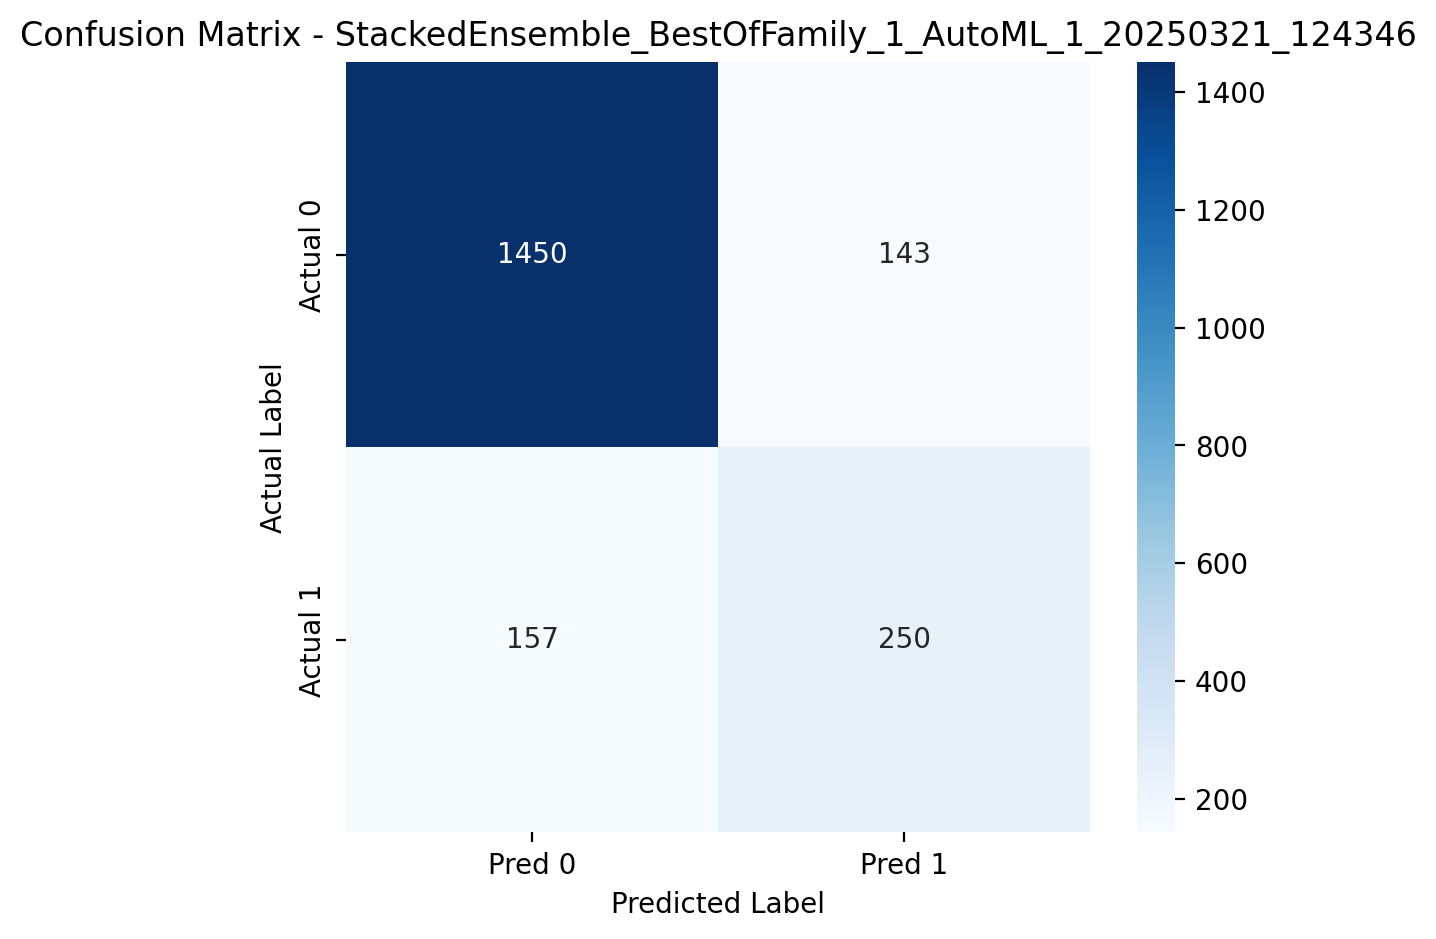

Evaluation for model: StackedEnsemble_BestOfFamily_1_AutoML_1_20250321_124346
           Metric     Value
0             AUC  0.856194
1           AUCPR  0.699036
2         LogLoss  0.340894
3          Recall  0.614251
4       Precision  0.636132
5        F1 Score  0.625000
6        Accuracy  0.850000
7  Best Threshold  0.361274


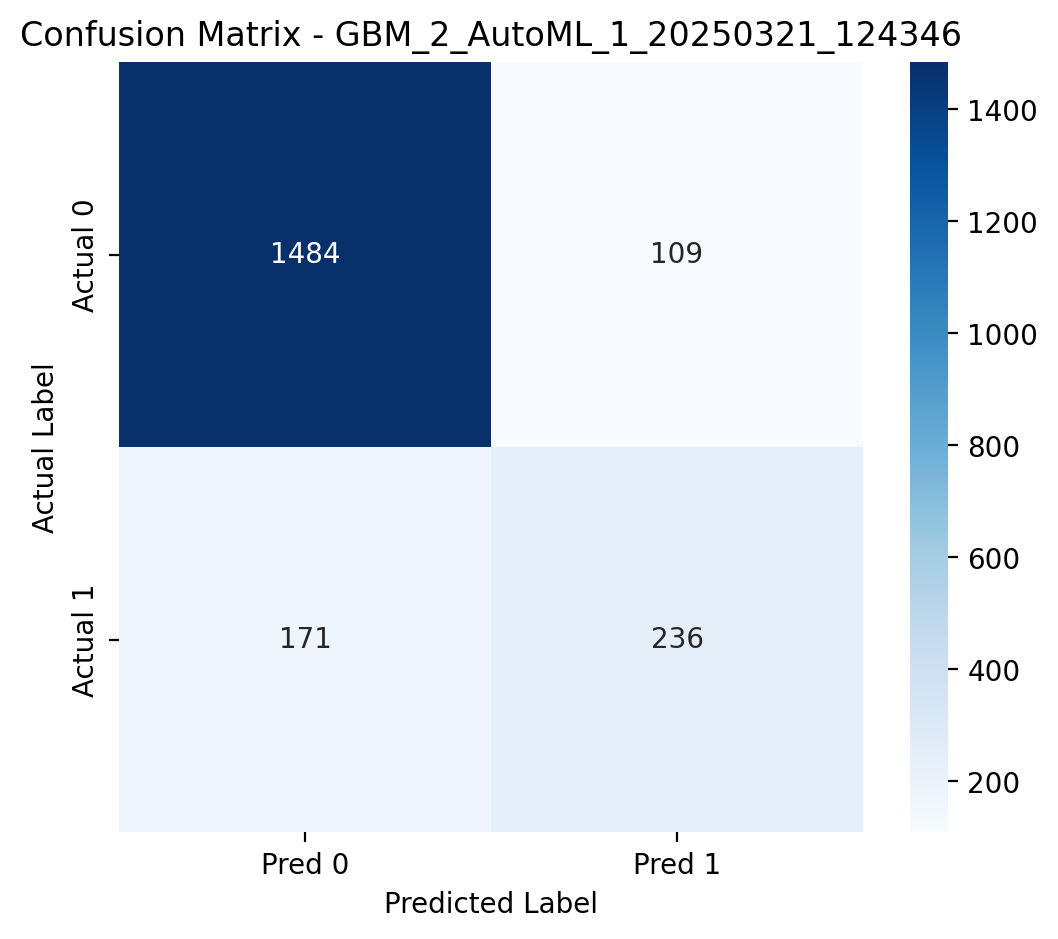

Evaluation for model: GBM_2_AutoML_1_20250321_124346
           Metric     Value
0             AUC  0.849184
1           AUCPR  0.693728
2         LogLoss  0.346111
3          Recall  0.579853
4       Precision  0.684058
5        F1 Score  0.627660
6        Accuracy  0.860000
7  Best Threshold  0.410400


In [ ]:
metrics_StackedEnsemble, cm_StackedEnsemble = evaluate_h2o_model(model_StackedEnsemble, test_h2o)
metrics_GBM, cm_GBM = evaluate_h2o_model(model_GBM, test_h2o)


Both models provided reasonable results, with F1 Scores of **0.625** and **0.627**. Given these baseline results, I will proceed with hyperparameter tuning to improve the model further. For demonstration purposes in this project, I will focus on tuning the **Gradient Boosting Classifier (GBC)**.  

### **Fine-Tuning GBC Model**
- Performed **Fine-Tuning** on the **Gradient Boosting Classifier (GBC)** using **Grid Search** for hyperparameter optimization.  
- Applied **Cross Validation** to ensure better model generalization and prevent overfitting.  


In [ ]:
hyper_params_gbm = {
    "max_depth": [3, 5, 7, 10],
    "learn_rate": [0.01, 0.05, 0.1],
    "sample_rate": [0.7, 0.8, 0.9],
    "col_sample_rate": [0.3, 0.5, 0.7]
}

search_criteria = {"strategy": "RandomDiscrete", "max_models": 10, "seed": 42}

gbm_grid = H2OGridSearch(
    model=H2OGradientBoostingEstimator(
        ntrees=100,
        stopping_metric="aucpr",
        nfolds=5,
        fold_assignment="Stratified",
        keep_cross_validation_predictions=True,
        seed=42
    ),
    hyper_params=hyper_params_gbm,
    search_criteria=search_criteria,
    grid_id="gbm_grid"
)

In [ ]:
gbm_grid.train(x=features, y=target, training_frame=train_h2o)


gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,col_sample_rate,learn_rate,max_depth,sample_rate,model_ids,logloss
,0.7,0.05,5.0,0.7,gbm_grid_model_6,0.3211924
,0.3,0.05,7.0,0.7,gbm_grid_model_10,0.3218438
,0.3,0.05,5.0,0.9,gbm_grid_model_2,0.3255138
,0.5,0.1,10.0,0.9,gbm_grid_model_3,0.3589664
,0.7,0.1,10.0,0.9,gbm_grid_model_9,0.3619246
,0.3,0.01,10.0,0.9,gbm_grid_model_5,0.3871391
,0.7,0.01,7.0,0.9,gbm_grid_model_1,0.3892093
,0.5,0.01,7.0,0.7,gbm_grid_model_8,0.3895363
,0.7,0.01,5.0,0.8,gbm_grid_model_7,0.4033342
,0.3,0.01,5.0,0.9,gbm_grid_model_4,0.4161334


In [ ]:
gbm_grid_perf = gbm_grid.get_grid(sort_by="f1", decreasing=True)
print(gbm_grid_perf)

Hyper-Parameter Search Summary: ordered by decreasing f1
    col_sample_rate    learn_rate    max_depth    sample_rate    model_ids          f1
--  -----------------  ------------  -----------  -------------  -----------------  --------
    0.7                0.05          5            0.7            gbm_grid_model_6   0.749952
    0.3                0.05          7            0.7            gbm_grid_model_10  0.749132
    0.3                0.05          5            0.9            gbm_grid_model_2   0.748074
    0.5                0.01          7            0.7            gbm_grid_model_8   0.743001
    0.3                0.01          5            0.9            gbm_grid_model_4   0.741068
    0.3                0.01          10           0.9            gbm_grid_model_5   0.738292
    0.7                0.01          7            0.9            gbm_grid_model_1   0.735542
    0.7                0.1           10           0.9            gbm_grid_model_9   0.734978
    0.7            

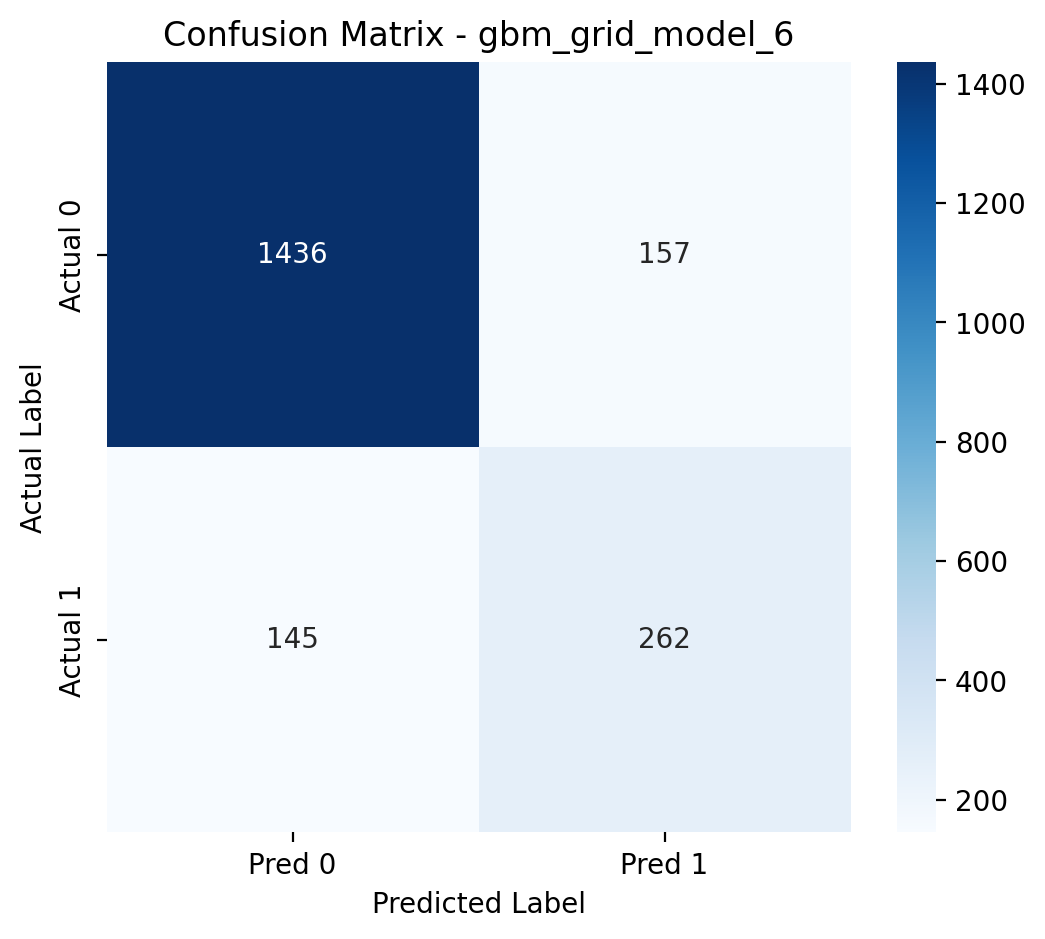

Evaluation for model: gbm_grid_model_6
           Metric     Value
0             AUC  0.859616
1           AUCPR  0.708750
2         LogLoss  0.337241
3          Recall  0.643735
4       Precision  0.625298
5        F1 Score  0.634383
6        Accuracy  0.849000
7  Best Threshold  0.336591


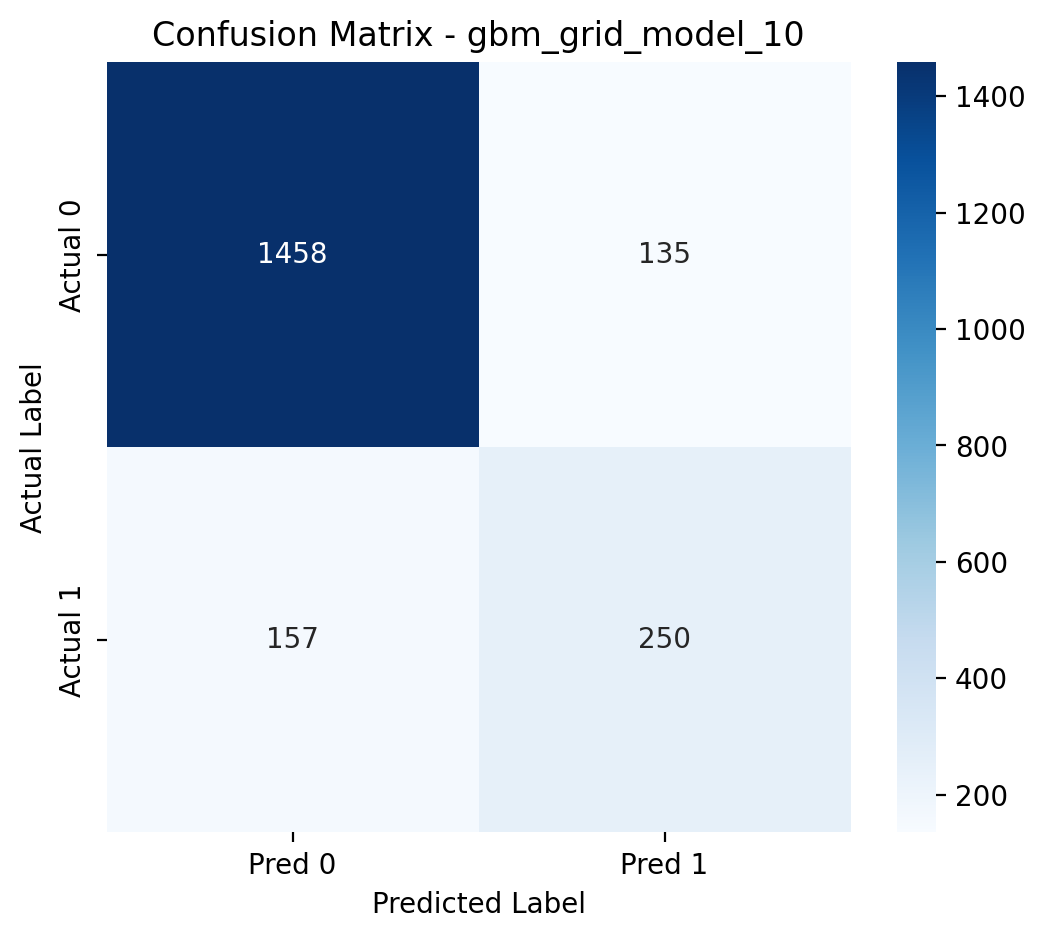

Evaluation for model: gbm_grid_model_10
           Metric     Value
0             AUC  0.854048
1           AUCPR  0.700961
2         LogLoss  0.342027
3          Recall  0.614251
4       Precision  0.649351
5        F1 Score  0.631313
6        Accuracy  0.854000
7  Best Threshold  0.382901


In [ ]:
metricsֹ_gbm1, cm_gbm1 = evaluate_h2o_model(gbm_grid[0], test_h2o)
metricsֹ_gbm2, cm_gbm2= evaluate_h2o_model(gbm_grid[1], test_h2o)

In [ ]:
# Save in Drive
def save_top_h2o_grid_models(grid, save_path=models_path, top_n=3, sort_by="f1"):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    grid_perf = grid.get_grid(sort_by=sort_by, decreasing=True)
    saved_models = []

    for i in range(min(top_n, len(grid_perf.model_ids))):
        model_id = grid_perf.model_ids[i]
        model = h2o.get_model(model_id)
        model_path = h2o.save_model(model=model, path=save_path, force=True)
        saved_models.append(model_path)
        print(f"Model {i+1} ({model_id}) saved at: {model_path}")

    return saved_models



In [ ]:
#saved_models = save_top_h2o_grid_models(gbm_grid, top_n=3)

In [ ]:
## Load

gbm_grid_model_1 = load_h2o_model("gbm_grid_model_10")
gbm_grid_model_2 = load_h2o_model("gbm_grid_model_6")
gbm_grid_model_3 = load_h2o_model("gbm_grid_model_2")

Model gbm_grid_model_10 loaded successfully!
Model gbm_grid_model_6 loaded successfully!
Model gbm_grid_model_2 loaded successfully!


## Parameters
Model metrics are presented to compare the performance of all evaluated models.  






In [ ]:
models_dict = {
    "StackedEnsemble": model_StackedEnsemble,
    "GBM_Original": model_GBM,
    "GBM_Grid_Model_1": gbm_grid_model_1,
    "GBM_Grid_Model_2": gbm_grid_model_2,
    "GBM_Grid_Model_3": gbm_grid_model_3
}

In [ ]:
def get_model_metrics(models_dict, test_data):
    model_metrics = []

    for model_name, model in models_dict.items():
        metrics, _ = extract_h2o_metrics(model, test_data)
        metrics["Model"] = model_name
        model_metrics.append(metrics)

    return pd.DataFrame(model_metrics)


In [ ]:
model_metrics = get_model_metrics(models_dict, test_h2o)
model_metrics_df=pd.DataFrame(model_metrics)


In [ ]:
model_metrics_df.sort_values('F1 Score')

,AUC,AUCPR,LogLoss,Recall,Precision,F1 Score,Accuracy,Best Threshold,Model
0,0.856194,0.699036,0.340894,0.614251,0.636132,0.625000,0.8500,0.361274,StackedEnsemble
4,0.859105,0.705317,0.339073,0.695332,0.568273,0.625414,0.8305,0.293797,GBM_Grid_Model_3
1,0.849184,0.693728,0.346111,0.579853,0.684058,0.627660,0.8600,0.410400,GBM_Original
2,0.854048,0.700961,0.342027,0.614251,0.649351,0.631313,0.8540,0.382901,GBM_Grid_Model_1
3,0.859616,0.708750,0.337241,0.643735,0.625298,0.634383,0.8490,0.336591,GBM_Grid_Model_2


## Best Model

The best-performing model, selected based on the highest F1-score, is presented.  


In [ ]:
best_model_name = model_metrics_df.loc[model_metrics_df["F1 Score"].idxmax(), "Model"]
best_model = models_dict[best_model_name]

print(f"Best model: {best_model_name}")
h2o_model = best_model

Best model: GBM_Grid_Model_2


In [ ]:
h2o_model_params = h2o_model.actual_params
h2o_model_params

{'model_id': 'gbm_grid_model_6',
 'training_frame': None,
 'validation_frame': None,
 'nfolds': 5,
 'keep_cross_validation_models': True,
 'keep_cross_validation_predictions': True,
 'keep_cross_validation_fold_assignment': False,
 'score_each_iteration': False,
 'score_tree_interval': 0,
 'fold_assignment': 'Modulo',
 'fold_column': None,
 'response_column': 'Exited',
 'ignored_columns': None,
 'ignore_const_cols': True,
 'offset_column': None,
 'weights_column': None,
 'balance_classes': False,
 'class_sampling_factors': None,
 'max_after_balance_size': 5.0,
 'max_confusion_matrix_size': 20,
 'ntrees': 100,
 'max_depth': 5,
 'min_rows': 10.0,
 'nbins': 20,
 'nbins_top_level': 1024,
 'nbins_cats': 1024,
 'r2_stopping': 1.7976931348623157e+308,
 'stopping_rounds': 0,
 'stopping_metric': 'AUCPR',
 'stopping_tolerance': 0.001,
 'max_runtime_secs': 0.0,
 'seed': 42,
 'build_tree_one_node': False,
 'learn_rate': 0.05,
 'learn_rate_annealing': 1.0,
 'distribution': 'bernoulli',
 'quantile_a

## Model Analysis  

To further analyze the selected best model, I will visualize key evaluation plots:  

- **Feature Importance** – Displays the most influential features in the model.  
- **SHAP Plot** – Explains the impact of each feature on individual predictions.  
- **Precision-Recall Curve** – Evaluates model performance, especially for imbalanced datasets.  

### Feature Importance

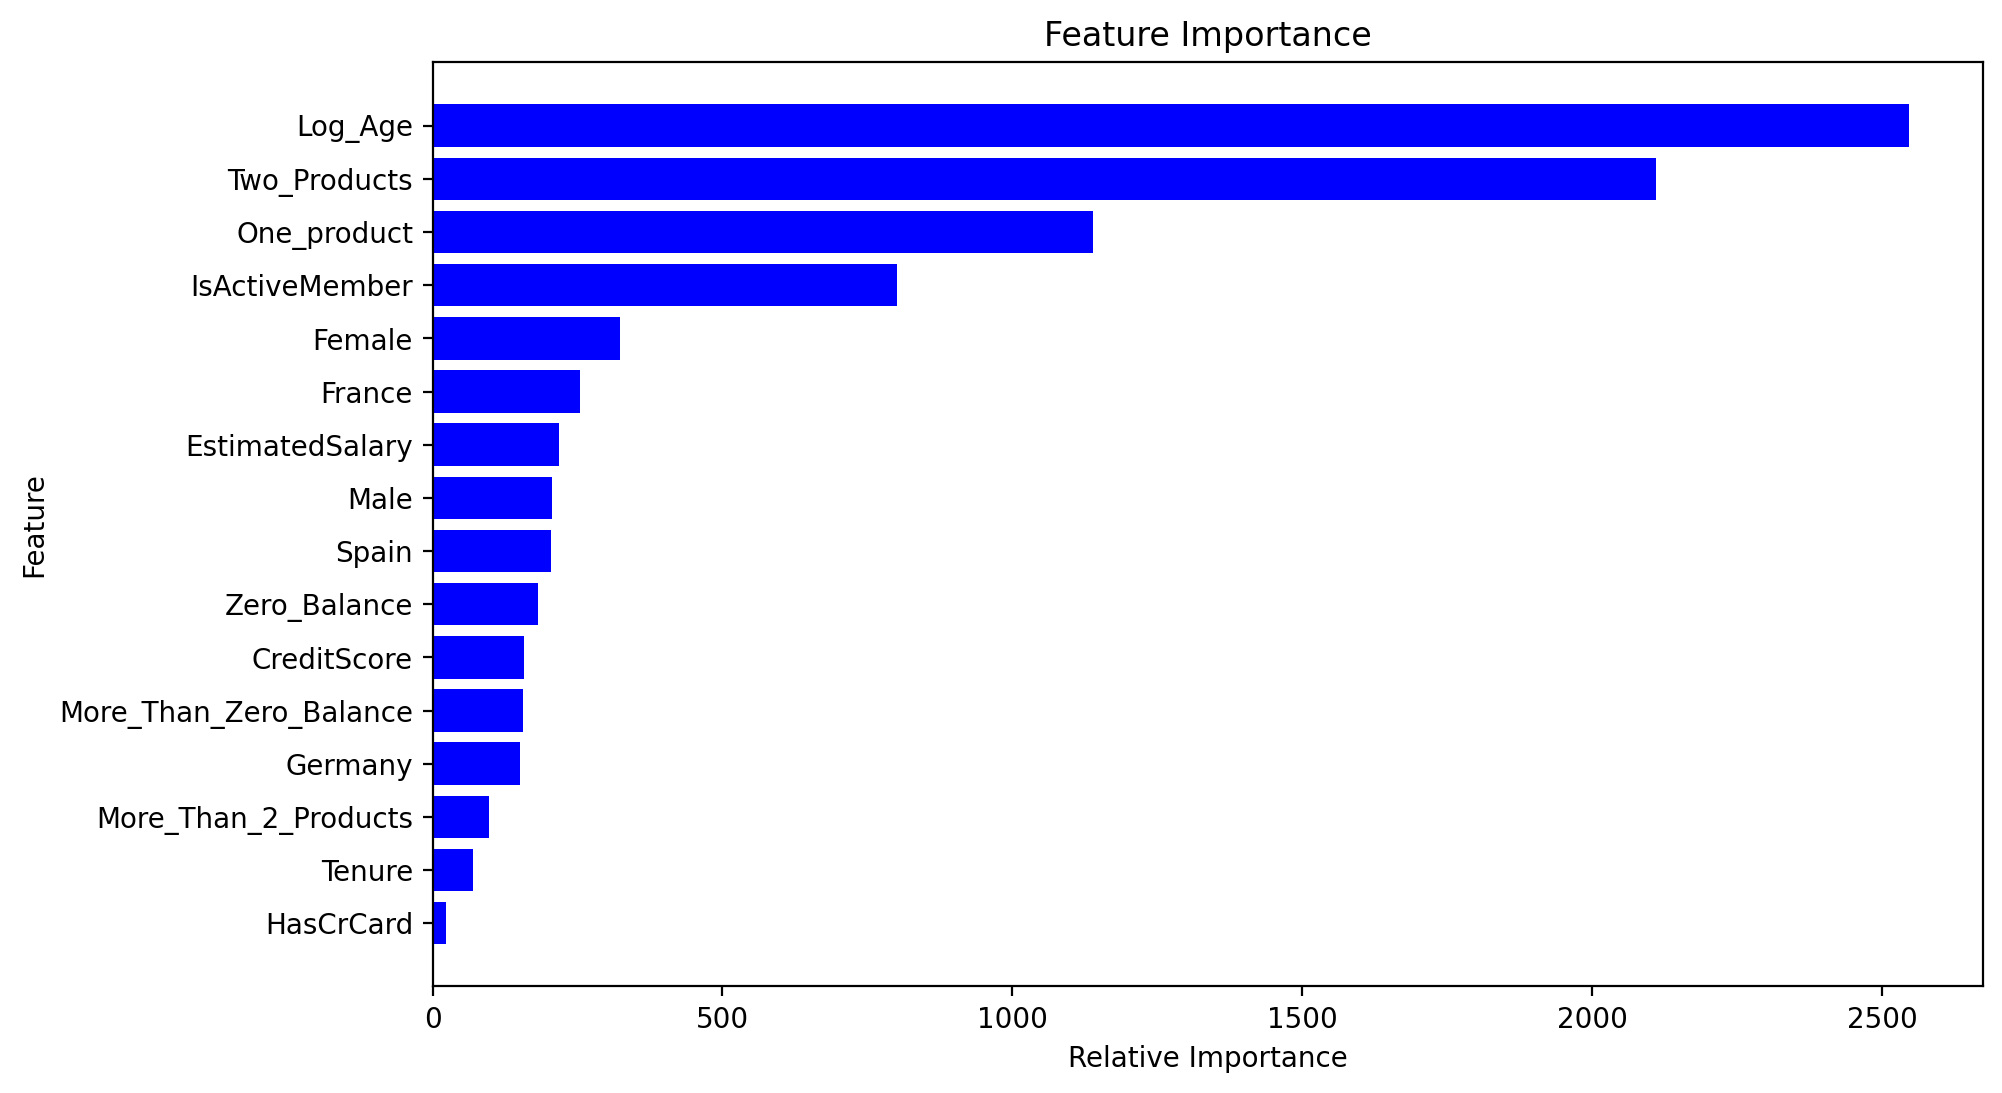

In [ ]:
feature_importance = h2o_model.varimp(use_pandas=True)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance["variable"], feature_importance["relative_importance"], color='blue')
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()

The **key factors** that significantly influence the deactivation of customers banking facilities are:

Age, Two_Products, One_Product, IsActiveMember and Female.

The minimal impact of features on the deactivation of customers' banking facilities are:

HasCrCard, Tenure, More_Than_2_Products and Germany.

### SHAP Plot
The SHAP Summary Plot shows how each feature influences churn predictions.

X-axis: SHAP value (positive → increases churn, negative → decreases churn).
Color: Feature value (red = high, blue = low)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
contributions progress: |████████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


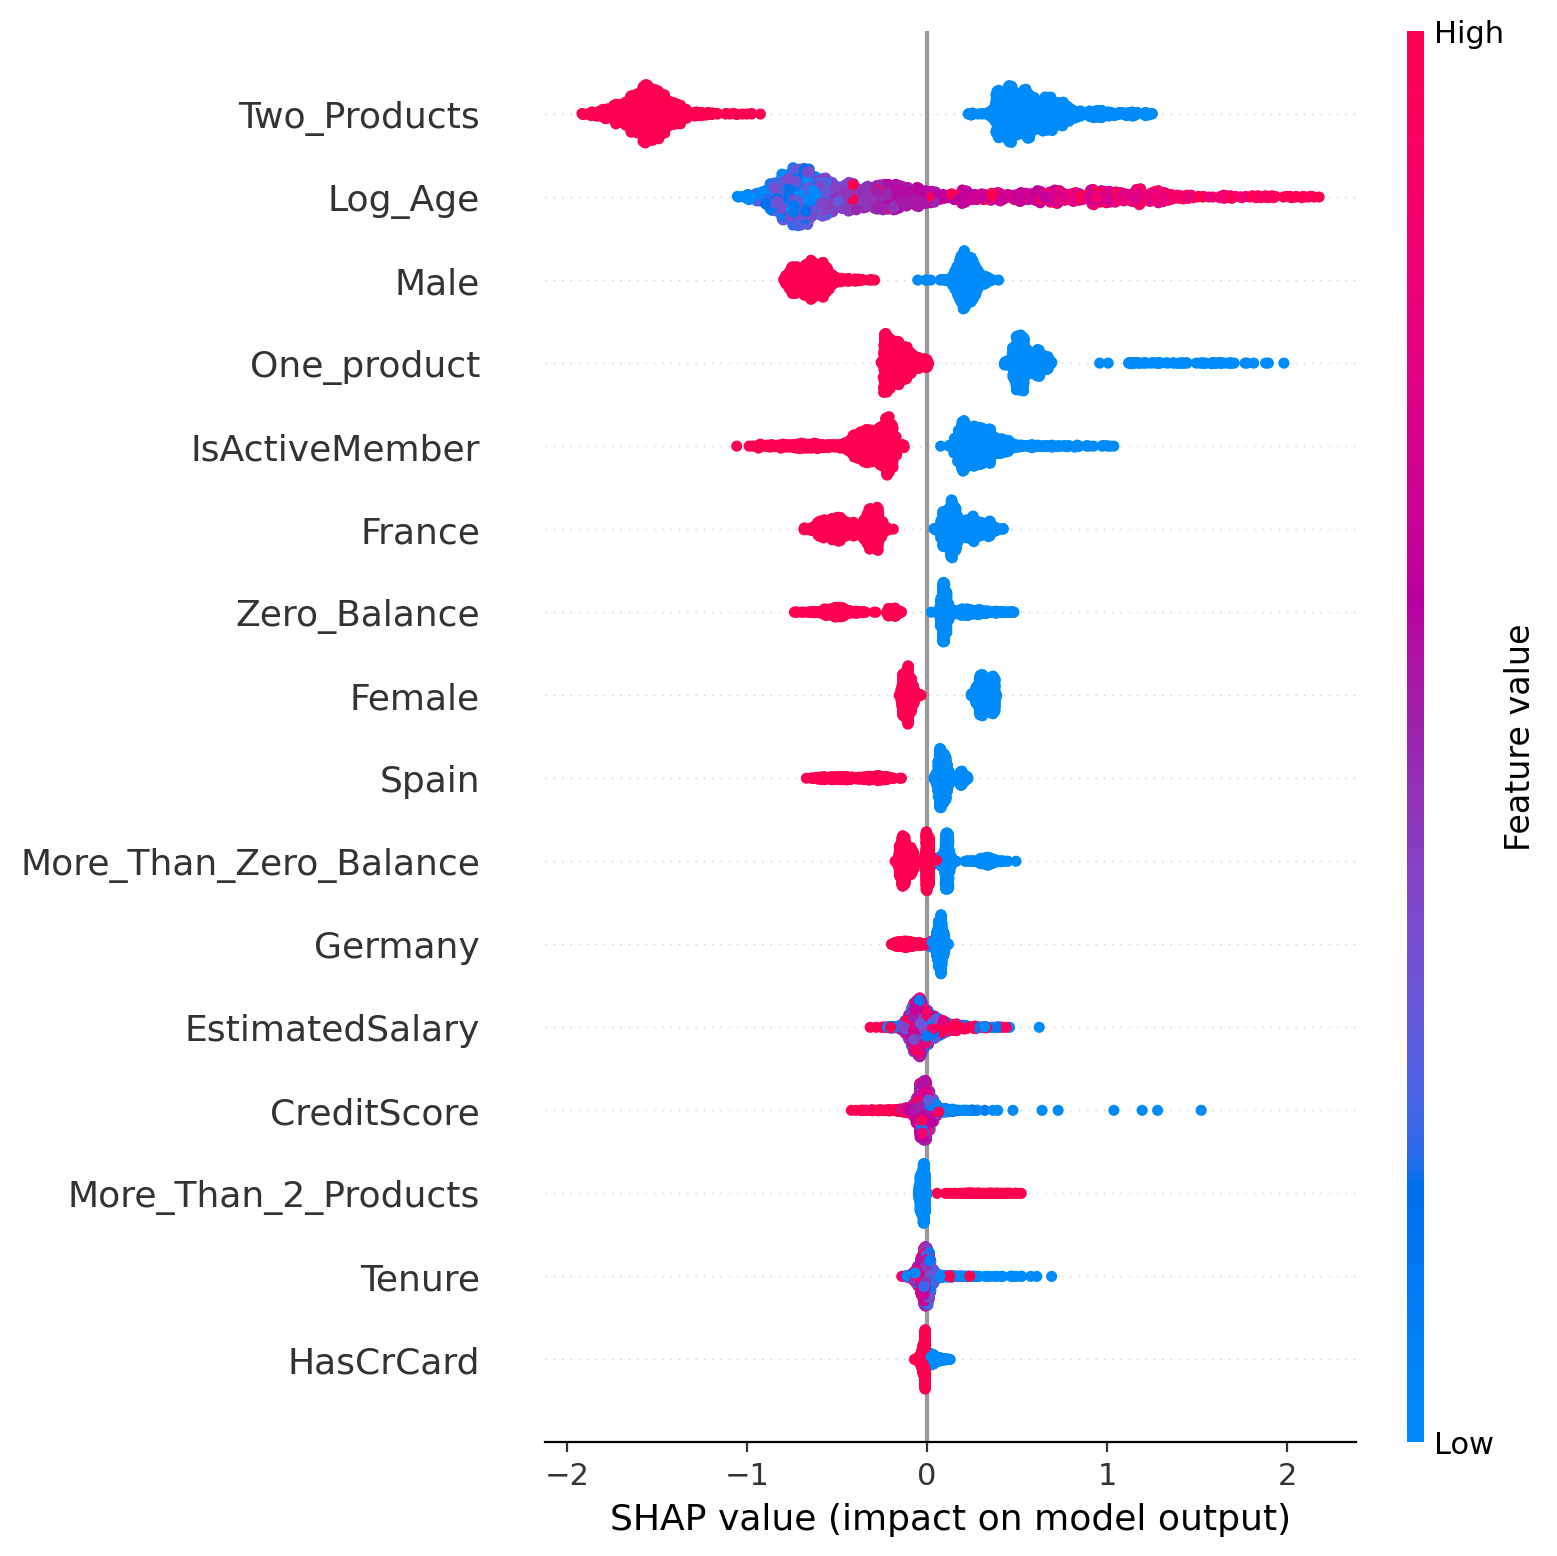

In [ ]:
shap_values = best_model.predict_contributions(h2o.H2OFrame(X_test))
shap_values_pd = shap_values.as_data_frame()
shap_values_pd.drop(columns=["BiasTerm"], inplace=True, errors="ignore")
shap_values_array = shap_values_pd.values
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_array, X_test, show=True)

#### SHAP Insights  

- Customers with **two banking products** are **less likely to churn**, as indicated by negative SHAP values for higher values of `Two_Products`.  
- **Older customers** tend to have a **higher likelihood of churning**, as their SHAP values are mostly positive for `Log_Age`.  


## Precision-Recall Curve  

The **Precision-Recall (PR) Curve** evaluates the model’s performance, especially in imbalanced datasets like customer churn prediction.  

This curve helps assess the trade-off between **capturing more true churn cases (high recall)** and **avoiding false positives (high precision)**. The optimal balance point is where the **F1 Score** is maximized.  


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


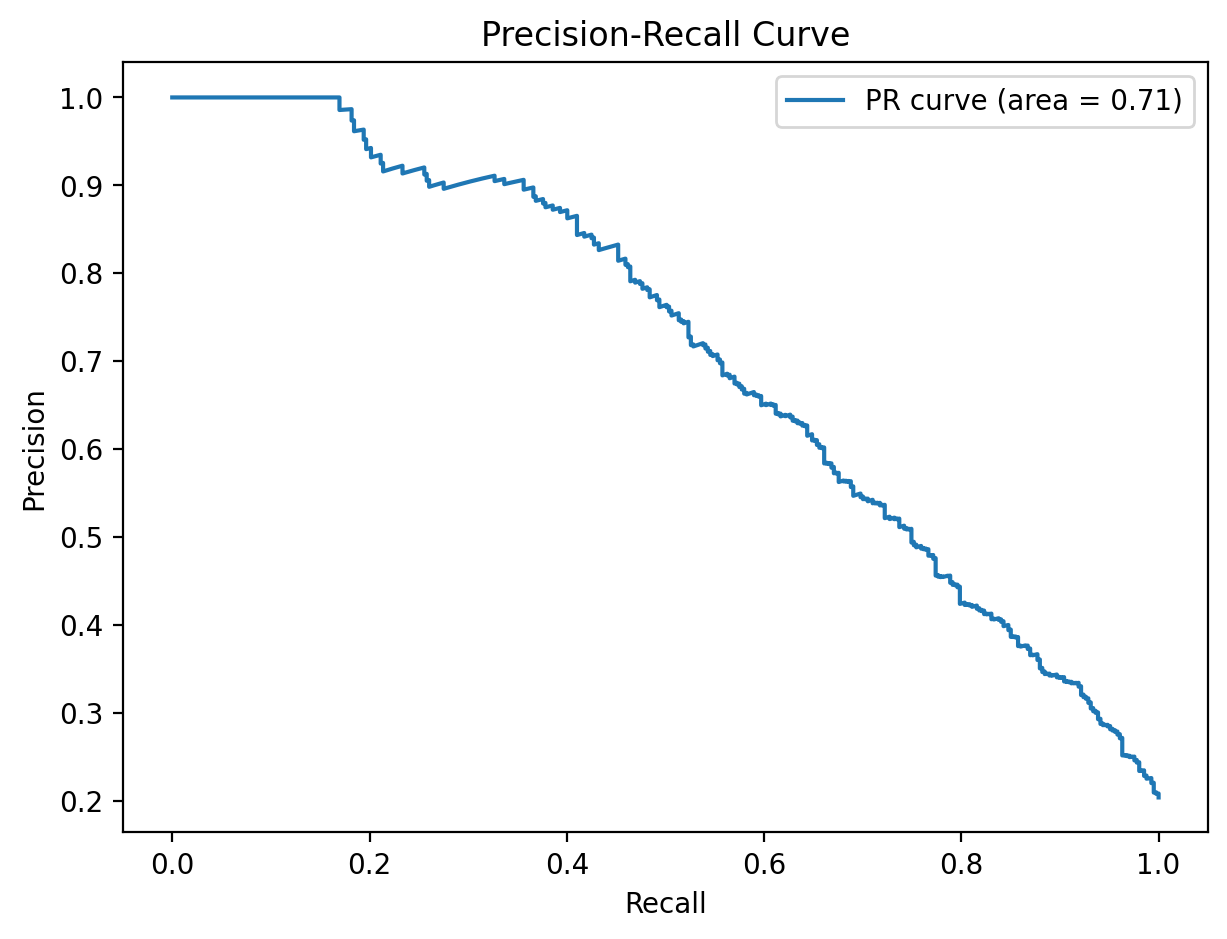

In [ ]:
predictions = best_model.predict(test_h2o).as_data_frame()
y_true = test_h2o["Exited"].as_data_frame().values.flatten()
y_pred_prob = predictions["p1"].values

precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

The PR-AUC score of 0.71 indicates a moderate ability to distinguish churners from non-churners, suggesting room for improvement in balancing false positives and false negatives.

## Save and Track with MLflow  

All models and their performance metrics are logged in **MLflow** for tracking, comparison, and reproducibility.  


### Setup

In [ ]:
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", MLFLOW_TRACKING_URI, "--port", "5000"])


mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

mlflow.set_experiment("Bank_Churn_Prediction")

In [ ]:
# Set up ngrok for exposing the MLflow UI
print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth")
conf.get_default().auth_token = getpass.getpass()

NGROK_AUTH_TOKEN = "my_token"


Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth
··········


In [ ]:
port = 5000
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel "{public_url}" -> "http://127.0.0.1:{port}"')


 * ngrok tunnel "https://cde4-34-125-77-177.ngrok-free.app" -> "http://127.0.0.1:5000"


## Save models in MLflow

In [ ]:
def log_models_to_mlflow(models_dict, model_metrics, test_data):

    example_input = test_data.head(rows=5).as_data_frame()

    for _, row in model_metrics.iterrows():
        model_name = row["Model"]
        model = models_dict[model_name]

        with mlflow.start_run(run_name=model_name):

            mlflow.log_metrics({
                "AUC": row["AUC"],
                "AUCPR": row["AUCPR"],
                "LogLoss": row["LogLoss"],
                "Recall": row["Recall"],
                "Precision": row["Precision"],
                "F1 Score": row["F1 Score"],
                "Accuracy": row["Accuracy"],
                "Best Threshold": row["Best Threshold"]
            })

            params = model.actual_params
            mlflow.log_params(params)

            mlflow.h2o.log_model(model, artifact_path=model_name,
                                 input_example=example_input,
                                 signature=mlflow.models.infer_signature(example_input))

            print(f"Model {model_name} logged successfully!")



In [ ]:
log_models_to_mlflow(models_dict, model_metrics_df, test_h2o)

##  MLflow Screen Shot

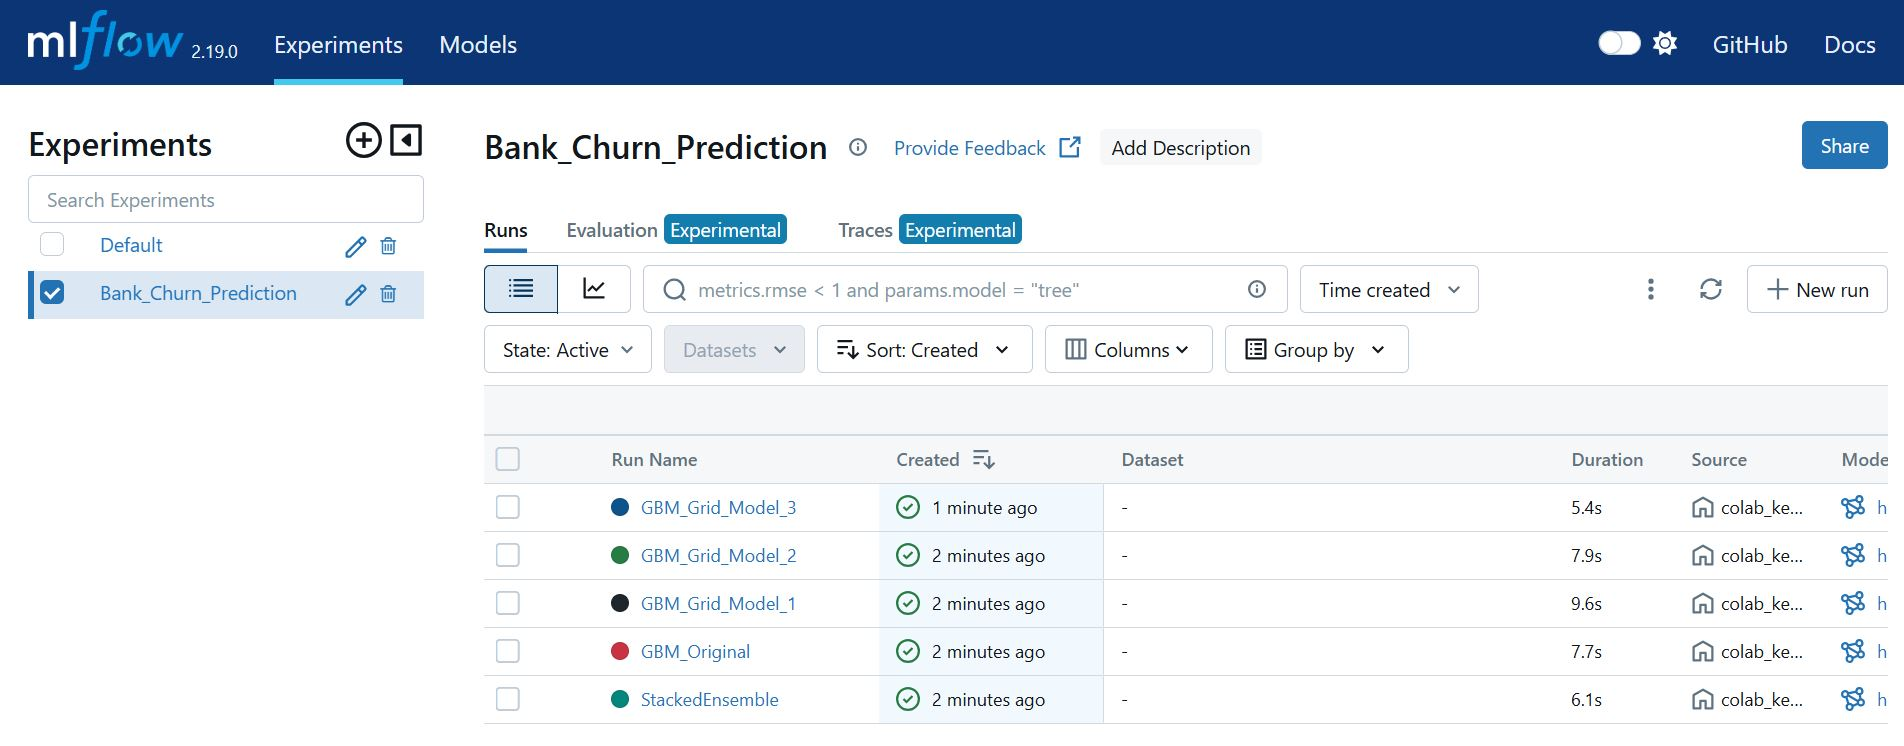

In [ ]:
from IPython.display import Image
Image__path="/content/drive/My Drive/Direct_Insurance/churn_prediction/Screen Shots/MLFLOW_Experiment.JPG"

display(Image(Image__path, width=800,height= 400))


## Customer Churn Prediction - Summary

The project focuses on **customer churn prediction** using **AutoML H2O**. Various models were evaluated to maximize the **F1-score**, aiming to identify churners while avoiding unnecessary investment in non-churners.  

### **Key Findings**
- **Gradient Boosting (GB)** emerged as the best model after AutoML tuning.  
- The final **F1-score = 0.634**, indicating room for improvement.  
- **Age** and **Two_Products** were the most influential features:  
  - Older customers tend to **churn more**.  
  - Customers with **two products** are more likely to **stay**.  
- All models were tracked using **MLflow**.

### **Potential Improvements**
1. **Feature Engineering Enhancements**  
   - For Example: **Tenure by Age Ratio**: Older customers with short tenure may indicate dissatisfaction, which could help refine churn risk prediction.  

2. **Exploring Alternative Models**  
   - **KNN**: Useful if customer similarity plays a role in churn behavior.  
   - **SVM**: Can be effective if the decision boundary between churners and non-churners is complex.  

3. **Refining the Business Objective**  
   - Should the model **maximize recall** (catch more churners at the cost of false positives)?  
   - Or should it **increase precision** (focus only on the most likely churners)?  

4. **Segment-Based Churn Prediction**  
Different customer profiles churn for different reasons, making a single model less effective.  
Possible segmentation: **Age Group, Location, and Balance.**  
- **Benefit:** More accurate predictions and targeted retention strategies.  

Further improvements should align with the business goal to optimize customer retention strategies.
